# imports & settings

In [2]:
import numpy as np
import pandas as pd
%precision %.3f

from os.path import join
from glob import glob
from tqdm import tqdm
import ntpath 
from copy import deepcopy

import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent

import sys  
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
import utils
from utils import *
RANDOM_STATE=utils.RANDOM_STATE
DATAROOT = utils.DATAROOT
import dataset

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import (
        plot_confusion_matrix,log_loss, balanced_accuracy_score, accuracy_score
        , f1_score, make_scorer, precision_score, recall_score, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import catboost
import warnings
from functools import reduce

from matplotlib import pyplot as plt

In [3]:
def perf_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    metrics = []
    y_pred_cls = np.rint(y_pred)    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        acc, acc_bal = accuracy_score(y_true, y_pred_cls), balanced_accuracy_score(y_true, y_pred_cls)
    metrics.append(dict(ACC=acc*100, ACC_BAL=acc_bal*100))

    return reduce(lambda a, b: dict(a, **b), metrics)

    
def group_inner_split(X_train,y_train, pids):
    inner_splitter = GroupKFold(n_splits=5)
    for dev_index, val_index in inner_splitter.split(X_train, y_train, groups = pids):
        return dev_index, val_index

def stratified_inner_split(X_train,y_train):
    inner_splitter = StratifiedKFold(n_splits=5)
    for dev_index, val_index in inner_splitter.split(X_train, y_train):
        return dev_index, val_index

    
    
def get_feature_names(df):
    return df.columns[df.columns.str.contains('#')].to_list()

def univariate_selection(X,y, topq):
    X_new = SelectKBest(chi2, k=topq).fit_transform(X, y)
    return X_new

## Function definitions for classification experiment

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skfeature.function.similarity_based import fisher_score
import xgboost as xgb


classifiers = {
    'lr':LogisticRegression(random_state = RANDOM_STATE, max_iter=500 ),
    'lr_lasso_C=0.1':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=500
        , C=0.1
    ),
    'lr_lasso_C=0.01':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=500
        , C=0.01
    ),
    'lr_lasso_C=0.1_maxiter=1000':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=1000
        , C=0.1
    ),
    'knn':KNeighborsClassifier(),
    'svm':SVC(probability=True),
    'gp':GaussianProcessClassifier(),
    'dt':DecisionTreeClassifier(random_state = RANDOM_STATE),
    'rf':RandomForestClassifier(random_state = RANDOM_STATE),
    'mlp':MLPClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gnb':GaussianNB(),
    'qda':QuadraticDiscriminantAnalysis(),
    'catboost': catboost.CatBoostClassifier(random_seed=RANDOM_STATE, eval_metric='AUC')    
    ,'xgboost':xgb.Booster()
    }

classifier_names = {
    'lr':'LogisticRegression'
    ,'lr_lasso_C=0.1':'lr_lasso_C=0.1'
    ,'lr_lasso_C=0.01':'lr_lasso_C=0.01'
    ,'lr_lasso_C=0.1_maxiter=1000':'lr_lasso_C=0.1_maxiter=1000'
    
    ,'knn':'KNeighborsClassifier',
    'svm':'SVM',
    'gp':'GaussianProcess',
    'dt':'DecisionTree',
    'rf':'RandomForest',
    'mlp':'Multi-layer Perceptron',
    'adaboost':'AdaBoost',
    'gnb':'Gaussian Naive Bayes',
    'qda':'QuadraticDiscriminantAnalysis',
    'catboost':'CatBoost'
    ,'xgboost':'XGBoost'
}




/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:


def run_classification(df, use_ray = True,  cat_features=None
    , classifier_name='catboost',
    feature_selection = None, experiment_name=''
) :                

    X = df[get_feature_names(df)]    
    y = df['is_opportune_moment'].replace({'receptive':1,'non-receptive':0}) 
    pids = df['pid']

    if use_ray:
        with on_ray(object_store_memory=2e10,num_cpus=20):        
            loso_results = LOSO_on_ray(X,y, pids,  feature_selection=feature_selection,
                                        cat_features=cat_features, 
                                        classifier_name=classifier_name)
            cv_results = CV10fold_on_ray(X,y, pids,  feature_selection=feature_selection,
                                        cat_features=cat_features, 
                                        classifier_name=classifier_name)
    else:
        loso_results = LOSO(X,y, pids, feature_selection=feature_selection,
                                        cat_features=cat_features,
                                   classifier_name=classifier_name)
        logo_results = LOGO_5fold(X,y, pids, feature_selection=feature_selection,
                                        cat_features=cat_features,
                                   classifier_name=classifier_name)

        cv_results = CV10fold(X,y, pids, feature_selection=feature_selection,
                                        cat_features=cat_features,
                                   classifier_name=classifier_name)
    results = pd.concat([
        loso_results
        ,logo_results
        ,cv_results
    ])
    results.insert(
        results.shape[1], 'experiment',experiment_name     
    )
    return results
    


In [6]:


def CV10fold(X,y, pids, cat_features=None, classifier_name='catboost',
 feature_selection = None):
    
    splitter =  StratifiedKFold(n_splits=10)    
    results = []    
    for i, (train_index, test_index) in tqdm(        
        enumerate(splitter.split(X, y, groups=pids))):           
        results.append(run_trial(X,y, pids, train_index,test_index,
                            cat_features=cat_features, classifier_name=classifier_name,
                             feature_selection = feature_selection,verbose=False))    
    results = pd.DataFrame(results).set_index('test_pid')    
    results.insert(results.shape[1],'CV_TYPE','10-fold')
    return results



def LOGO_5fold(X,y, pids, cat_features=None, classifier_name='catboost',
 feature_selection = None):
    
    splitter =  GroupKFold(
        n_splits=5
    )
    
    results = []    
    for i, (train_index, test_index) in tqdm(
        enumerate(splitter.split(X, y, groups=pids))):        
        results.append(run_trial(X,y, pids, train_index,test_index,
                            cat_features=cat_features, classifier_name=classifier_name,
                             feature_selection = feature_selection,verbose=False))    
    results = pd.DataFrame(results).set_index('test_pid')    
    results.insert(results.shape[1],'CV_TYPE','LOGO_5fold')
    return results


def LOSO(X,y, pids, cat_features=None, classifier_name='catboost',
 feature_selection = None):
    
    splitter =  GroupKFold(
        n_splits=len(np.unique(pids))
    )
    
    results = []    
    for i, (train_index, test_index) in tqdm(
        enumerate(splitter.split(X, y, groups=pids))):        
        results.append(run_trial(X,y, pids, train_index,test_index,
                            cat_features=cat_features, classifier_name=classifier_name,
                             feature_selection = feature_selection,verbose=False))    
    results = pd.DataFrame(results).set_index('test_pid')    
    results.insert(results.shape[1],'CV_TYPE','LOSO')
    return results

In [7]:
def CV10fold_on_ray(X,y, pids, cat_features=None, classifier_name='catboost',
 feature_selection = None):
     
    splitter =  StratifiedKFold(n_splits=10)
    
    func = ray.remote(run_trial).remote
    
    results = []    
    for i, (train_index, test_index) in enumerate(
        splitter.split(X, y, groups=pids)):                        
        results.append(func(X,y, pids, train_index,test_index,                            
                            cat_features=cat_features, classifier_name=classifier_name,
                             feature_selection = feature_selection,verbose=False))
    results = ray.get(results)
    results = pd.DataFrame(results).set_index('test_pid')
    results.insert(results.shape[1],'CV_TYPE','10-fold')
    return results

def LOSO_on_ray(X,y, pids, cat_features=None, classifier_name='catboost',
 feature_selection = None):
     
    splitter =  GroupKFold(n_splits=len(np.unique(pids)))
    
    func = ray.remote(run_trial).remote
    
    results = []    
    for i, (train_index, test_index) in enumerate(splitter.split(X, y, groups=pids)):                
        results.append(func(X,y, pids, train_index,test_index,                            
                            cat_features=cat_features, classifier_name=classifier_name,
                             feature_selection = feature_selection,verbose=False))
    results = ray.get(results)
    results = pd.DataFrame(results).set_index('test_pid')
    results.insert(results.shape[1],'CV_TYPE','LOSO')
    return results


#### run_trial

In [8]:
from sklearn.linear_model import  Lasso

def run_trial(X, y,pids,  train_index,test_index, verbose,            
              feature_selection = None, cat_features=None, 
              classifier_name='catboost'):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    
    if feature_selection['status']:
        if feature_selection['method']=='fisher_score':
            keep_ratio=feature_selection['keep_ratio']
            num_features_to_keep = int(keep_ratio*X_train.shape[1])            
            score = fisher_score.fisher_score(X_train.values, y_train.values)
        
            idx = fisher_score.feature_ranking(score)        
            X_train = X_train.iloc[:, np.array(idx[0:num_features_to_keep])]
        elif feature_selection['method']=='LASSO':
            cv = StratifiedKFold(shuffle= True, random_state=RANDOM_STATE)
    
            classifier = Lasso(tol=1e-3)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                classifier.fit(X=X_train, y=y_train)
            coef=np.abs(classifier.coef_)
            I = coef.argsort()
            keep_ratio=feature_selection['keep_ratio']
            num_features_to_keep = int(keep_ratio*X_train.shape[1])            

            X_train =  X_train[X_train.columns[I[-1*num_features_to_keep:]]]
            
            
        
    feature_names =X_train.columns.tolist()
    if verbose:  
        print("X_train.shape",X_train.shape)

    clf = classifiers[classifier_name]

    if classifier_name=='catboost':
                
        d_train = catboost.Pool(
            data = X_train,
            label = y_train,
            feature_names = feature_names,
            cat_features = cat_features
        )
        
        clf.fit(X = d_train,          
           verbose_eval=False,
           early_stopping_rounds=20,
                #plot=True
        )
    else:
        clf.fit(X_train, y_train)

        
    prob = clf.predict_proba(X.iloc[test_index][feature_names])[:,1]
    test_metrics = perf_metrics(y.iloc[test_index], prob)    

    prob = clf.predict_proba(X.iloc[train_index][feature_names])[:,1]
    train_metrics = perf_metrics(y.iloc[train_index], prob)

    test_pid = pids.iloc[test_index].unique()[0]    
    
    return {'test_pid':test_pid, 'test_bal_acc':test_metrics['ACC_BAL'],
        'train_bal_acc':train_metrics['ACC_BAL']    
    }


## get_colliniear_features

In [220]:
def get_colliniear_features(multi_colliniearity_df,MC_threshold = .5):
    # correlation threshold for multi colliniearity to be considered bad

    excluded_features = []
    for i in multi_colliniearity_df.index: # 1: excludues disturbance
        if i in excluded_features:  # no need to check for colliniearity if th efeature is already excluded
            continue

        M = multi_colliniearity_df[i]>MC_threshold
        M[i]=False
        collinier_features = multi_colliniearity_df[i][M].index.tolist()
        excluded_features+=multi_colliniearity_df[i][M].index.tolist()
    return list(set(excluded_features))

# Experiment

## Load Labels

In [9]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(join(DATAROOT,'binned_esm_data.csv'), 
 dtype=LABEL_DTYPES,
                     parse_dates=['timestamp'])

labels.set_index(['pid','timestamp'], inplace=True)
labels.shape

(3334, 20)

In [1]:
labels.head()

NameError: name 'labels' is not defined

## Establishing baseline model performance on FULL dataset

### Aggregated features

In [48]:
windows = {
    '90MIN': 90 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=20):    
    for window_name, window_size  in windows.items():
        sub_features = dataset.parallellize_extract_sub(
            labels=labels, 
            w_name=window_name,
            w_size = window_size,
            use_ray=False
        )


  0%|          | 0/59 [20:41:37<?, ?it/s]


In [52]:
sub_features



appUsage_appPackage#90MIN#15MIN#ETP  \
pid  timestamp           sub_timestamp                                              
718  2019-05-08 10:00:36 2019-05-08 08:30:36                                  NaN   
                         2019-05-08 08:45:36                                  NaN   
                         2019-05-08 09:00:36                             1.020769   
                         2019-05-08 09:15:36                             0.223326   
                         2019-05-08 09:30:36                             0.000000   
...                                                                           ...   
1511 2019-05-22 21:08:00 2019-05-22 19:53:00                             1.242750   
                         2019-05-22 20:08:00                             1.226734   
                         2019-05-22 20:23:00                             0.000000   
                         2019-05-22 20:38:00                             0.000000   
                         2019-05-22 20:53:00                             0.040012   

                                              appUsage_appPackage#90MIN#15MIN#ASC  \
pid  timestamp           sub_timestamp                                              
718  2019-05-08 10:00:36 2019-05-08 08:30:36                                  NaN   
                         2019-05-08 08:45:36                                  NaN   
                         2019-05-08 09:00:36                                  4.0   
                         2019-05-08 09:15:36                                  8.0   
                         2019-05-08 09:30:36                                  0.0   
...                                                                           ...   
1511 2019-05-22 21:08:00 2019-05-22 19:53:00                                 29.0   
                         2019-05-22 20:08:00                                 11.0   
                         2019-05-22 20:23:00                                  0.0   
                         2019-05-22 20:38:00                                  0.0   
                         2019-05-22 20:53:00                                  2.0   

                                              appUsage_appCategory#90MIN#15MIN#ETP  \
pid  timestamp           sub_timestamp                                               
718  2019-05-08 10:00:36 2019-05-08 08:30:36                                   NaN   
                         2019-05-08 08:45:36                                   NaN   
                         2019-05-08 09:00:36                              0.952607   
                         2019-05-08 09:15:36                              0.223326   
                         2019-05-08 09:30:36                              0.000000   
...                                                                            ...   
1511 2019-05-22 21:08:00 2019-05-22 19:53:00                              0.991142   
                         2019-05-22 20:08:00                              0.910513   
                         2019-05-22 20:23:00                              0.000000   
                         2019-05-22 20:38:00                              0.000000   
                         2019-05-22 20:53:00                              0.000000   

                                              appUsage_appCategory#90MIN#15MIN#ASC  \
pid  timestamp           sub_timestamp                                               
718  2019-05-08 10:00:36 2019-05-08 08:30:36                                   NaN   
                         2019-05-08 08:45:36                                   NaN   
                         2019-05-08 09:00:36                                   3.0   
                         2019-05-08 09:15:36                                   8.0   
                         2019-05-08 09:30:36                                   0.0   
...                                                                            ...   
1511 2019-05-22 21:08:00 20

In [55]:
sub_features.isnull().sum(axis=0)

appUsage_appPackage#90MIN#15MIN#ETP                            163
appUsage_appPackage#90MIN#15MIN#ASC                            163
appUsage_appCategory#90MIN#15MIN#ETP                           163
appUsage_appCategory#90MIN#15MIN#ASC                           163
appUsage_appCategory#90MIN#15MIN#SUP:Social/Communication     8080
                                                             ...  
appUsage_appCategory#90MIN#15MIN#SUP:Music/Audio             19293
activity_event#90MIN#15MIN#SUP:ON_BICYCLE                    19219
connection_type#90MIN#15MIN#SUP:MOBILE                       18918
battery_status#90MIN#15MIN#SUP:NOT_CHARGING                  19753
battery_plugState#90MIN#15MIN#SUP:WIRELESS                   19516
Length: 389, dtype: int64

In [613]:
sub_features = deepcopy(sub_features)
sub_features = impute_by_filling_support_features(sub_features)
sub_features = impute_with_mean_of_participant(sub_features)
sub_features.isnull().sum(axis=0).sort_values(ascending=False).sum()

  0%|          | 0/76 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 76/76 [00:05<00:00, 14.91it/s]


battery_temperature#6HR#30MIN#MED            0
accelerometer_Y#6HR#30MIN#MAXLAG             0
accelerometer_Z#6HR#30MIN#MAX                0
accelerometer_Z#6HR#30MIN#MIN                0
accelerometer_Z#6HR#30MIN#MED                0
                                            ..
data_RX2TX#6HR#30MIN#VAR                     0
data_RX2TX#6HR#30MIN#AVG                     0
data_RX2TX#6HR#30MIN#BEP                     0
data_RX2TX#6HR#30MIN#MAX                     0
battery_status#6HR#30MIN#SUP:NOT_CHARGING    0
Length: 378, dtype: int64

In [614]:
agg_feature = sub_features.groupby(['pid','timestamp']).agg(['mean','std'])
agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
agg_feature = drop_zero_varience_features(agg_feature)
agg_feature.to_csv(f'features/set_whole-aggregated_features.csv')


0 from total of 756 is dropped


In [615]:
agg_feature.head()

battery_temperature#6HR#30MIN#MED|mean  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                               32.124689   
     2019-05-16 13:42:00                               31.949130   
     2019-05-16 14:25:00                               31.392499   
     2019-05-16 15:12:00                               31.340613   
     2019-05-16 16:39:00                               30.746931   

                          battery_temperature#6HR#30MIN#MED|std  \
pid  timestamp                                                    
1501 2019-05-16 12:14:00                               3.693202   
     2019-05-16 13:42:00                               4.075841   
     2019-05-16 14:25:00                               4.033048   
     2019-05-16 15:12:00                               4.436645   
     2019-05-16 16:39:00                               3.641371   

                          battery_temperature#6HR#30MIN#MIN|mean  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                               30.542188   
     2019-05-16 13:42:00                               30.341911   
     2019-05-16 14:25:00                               29.583709   
     2019-05-16 15:12:00                               29.464643   
     2019-05-16 16:39:00                               28.743993   

                          battery_temperature#6HR#30MIN#MIN|std  \
pid  timestamp                                                    
1501 2019-05-16 12:14:00                               2.863941   
     2019-05-16 13:42:00                               3.425446   
     2019-05-16 14:25:00                               3.132788   
     2019-05-16 15:12:00                               3.561527   
     2019-05-16 16:39:00                               2.469796   

                          battery_temperature#6HR#30MIN#MAX|mean  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                               33.646975   
     2019-05-16 13:42:00                               34.297257   
     2019-05-16 14:25:00                               33.703329   
     2019-05-16 15:12:00                               33.591363   
     2019-05-16 16:39:00                               32.804119   

                          battery_temperature#6HR#30MIN#MAX|std  \
pid  timestamp                                                    
1501 2019-05-16 12:14:00                               4.177936   
     2019-05-16 13:42:00                               4.664873   
     2019-05-16 14:25:00                               5.190109   
     2019-05-16 15:12:00                               5.165243   
     2019-05-16 16:39:00                               4.243011   

                          battery_temperature#6HR#30MIN#BEP|mean  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                2.068226   
     2019-05-16 13:42:00                                2.031325   
     2019-05-16 14:25:00                                2.020358   
     2019-05-16 15:12:00                                2.058733   
     2019-05-16 16:39:00                                2.049320   

                          battery_temperature#6HR#30MIN#BEP|std  \
pid  timestamp                                                    
1501 2019-05-16 12:14:00                               0.129876   
     2019-05-16 13:42:00                               0.177651   
     2019-05-16 14:25:00                               0.160897   
     2019-05-16 15:12:00                               0.188014   
     2019-05-16 16:39:00                               0.177886   

                          battery_temperature#6HR#30MIN#AVG|mean  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                               32.140469   
     2019-05-16 13:42:00          

- correlation based feature selection

In [621]:
agg_feature.index

MultiIndex([('1501', '2019-05-16 12:14:00'),
            ('1501', '2019-05-16 13:42:00'),
            ('1501', '2019-05-16 14:25:00'),
            ('1501', '2019-05-16 15:12:00'),
            ('1501', '2019-05-16 16:39:00'),
            ('1501', '2019-05-17 12:05:00'),
            ('1501', '2019-05-17 18:01:00'),
            ('1501', '2019-05-17 21:11:00'),
            ('1501', '2019-05-18 15:08:00'),
            ('1501', '2019-05-18 15:49:00'),
            ...
            ( '729', '2019-05-14 13:41:00'),
            ( '729', '2019-05-14 15:13:00'),
            ( '729', '2019-05-14 15:58:00'),
            ( '729', '2019-05-14 16:41:00'),
            ( '729', '2019-05-14 17:28:00'),
            ( '729', '2019-05-14 18:10:00'),
            ( '729', '2019-05-14 18:53:00'),
            ( '729', '2019-05-14 19:33:00'),
            ( '729', '2019-05-14 20:16:00'),
            ( '729', '2019-05-14 21:02:00')],
           names=['pid', 'timestamp'], length=3351)

In [628]:
labels=labels.sort_index()
agg_feature = agg_feature.sort_index()


In [629]:
X = deepcopy(agg_feature)
X.insert(0,'disturbance', labels['disturbance'].values)
multi_colliniearity_df = X.corr().sort_values('disturbance',key=abs, ascending=False).iloc[1:,1:]
multi_colliniearity_df.head()

,battery_temperature#6HR#30MIN#MED|mean,battery_temperature#6HR#30MIN#MED|std,battery_temperature#6HR#30MIN#MIN|mean,battery_temperature#6HR#30MIN#MIN|std,battery_temperature#6HR#30MIN#MAX|mean,battery_temperature#6HR#30MIN#MAX|std,battery_temperature#6HR#30MIN#BEP|mean,battery_temperature#6HR#30MIN#BEP|std,battery_temperature#6HR#30MIN#AVG|mean,battery_temperature#6HR#30MIN#AVG|std,...,battery_plugState#6HR#30MIN#SUP:USB|mean,battery_plugState#6HR#30MIN#SUP:USB|std,appUsage_appCategory#6HR#30MIN#SUP:Music/Audio|mean,appUsage_appCategory#6HR#30MIN#SUP:Music/Audio|std,bandUV_indexLevel#6HR#30MIN#SUP:MEDIUM|mean,bandUV_indexLevel#6HR#30MIN#SUP:MEDIUM|std,battery_plugState#6HR#30MIN#SUP:WIRELESS|mean,battery_plugState#6HR#30MIN#SUP:WIRELESS|std,battery_status#6HR#30MIN#SUP:NOT_CHARGING|mean,battery_status#6HR#30MIN#SUP:NOT_CHARGING|std
data_RX2TX#6HR#30MIN#MAX|std,0.139588,0.215937,0.071890,0.234260,0.181252,0.152180,0.202044,-0.043773,0.139966,0.210389,...,-0.014015,0.006000,0.087371,0.098854,0.001878,-0.000284,0.020135,0.044152,-0.003882,-0.009667
data_RX2TX#6HR#30MIN#MAX|mean,0.226129,0.135476,0.150752,0.193314,0.260308,0.045800,0.180554,-0.109662,0.225661,0.128462,...,-0.028303,0.002437,0.128840,0.127288,0.012918,0.011848,-0.016563,-0.002653,-0.011314,-0.015316
data_RX2TX#6HR#30MIN#VAR|std,0.049597,0.069212,0.022711,0.094802,0.060365,0.023516,0.100175,-0.065986,0.049132,0.065196,...,-0.020754,-0.006442,0.031288,0.039297,-0.007721,-0.009422,-0.010391,-0.001643,-0.009109,-0.011260
data_RX2TX#6HR#30MIN#LTS|std,0.104894,0.103412,0.052458,0.124211,0.132933,0.044897,0.163574,-0.077767,0.104348,0.093552,...,-0.030467,-0.012843,0.047947,0.054429,0.015050,0.012831,0.021869,0.054410,-0.011634,-0.014569
data_RX2TX#6HR#30MIN#LTI|std,0.069375,0.100282,0.023524,0.115327,0.095047,0.055004,0.152350,-0.057155,0.068664,0.092287,...,-0.026582,-0.009867,0.038422,0.043916,0.018054,0.016210,0.012023,0.040711,-0.017946,-0.021746


In [630]:
agg_feature.shape, labels.shape

((3351, 756), (3351, 21))

In [631]:
X.corr().sort_values('disturbance',key=abs, ascending=False)

,disturbance,battery_temperature#6HR#30MIN#MED|mean,battery_temperature#6HR#30MIN#MED|std,battery_temperature#6HR#30MIN#MIN|mean,battery_temperature#6HR#30MIN#MIN|std,battery_temperature#6HR#30MIN#MAX|mean,battery_temperature#6HR#30MIN#MAX|std,battery_temperature#6HR#30MIN#BEP|mean,battery_temperature#6HR#30MIN#BEP|std,battery_temperature#6HR#30MIN#AVG|mean,...,battery_plugState#6HR#30MIN#SUP:USB|mean,battery_plugState#6HR#30MIN#SUP:USB|std,appUsage_appCategory#6HR#30MIN#SUP:Music/Audio|mean,appUsage_appCategory#6HR#30MIN#SUP:Music/Audio|std,bandUV_indexLevel#6HR#30MIN#SUP:MEDIUM|mean,bandUV_indexLevel#6HR#30MIN#SUP:MEDIUM|std,battery_plugState#6HR#30MIN#SUP:WIRELESS|mean,battery_plugState#6HR#30MIN#SUP:WIRELESS|std,battery_status#6HR#30MIN#SUP:NOT_CHARGING|mean,battery_status#6HR#30MIN#SUP:NOT_CHARGING|std
disturbance,1.000000,0.018484,-0.023872,0.017827,-0.054899,0.027889,0.000125,0.012134,0.058337,0.019939,...,-0.027451,-0.037902,0.031467,0.029456,0.022229,0.020383,0.106905,0.087602,-0.025662,-0.024766
data_RX2TX#6HR#30MIN#MAX|std,-0.230922,0.139588,0.215937,0.071890,0.234260,0.181252,0.152180,0.202044,-0.043773,0.139966,...,-0.014015,0.006000,0.087371,0.098854,0.001878,-0.000284,0.020135,0.044152,-0.003882,-0.009667
data_RX2TX#6HR#30MIN#MAX|mean,-0.197353,0.226129,0.135476,0.150752,0.193314,0.260308,0.045800,0.180554,-0.109662,0.225661,...,-0.028303,0.002437,0.128840,0.127288,0.012918,0.011848,-0.016563,-0.002653,-0.011314,-0.015316
data_RX2TX#6HR#30MIN#VAR|std,-0.184421,0.049597,0.069212,0.022711,0.094802,0.060365,0.023516,0.100175,-0.065986,0.049132,...,-0.020754,-0.006442,0.031288,0.039297,-0.007721,-0.009422,-0.010391,-0.001643,-0.009109,-0.011260
data_RX2TX#6HR#30MIN#LTS|std,-0.175459,0.104894,0.103412,0.052458,0.124211,0.132933,0.044897,0.163574,-0.077767,0.104348,...,-0.030467,-0.012843,0.047947,0.054429,0.015050,0.012831,0.021869,0.054410,-0.011634,-0.014569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
battery_temperature#6HR#30MIN#MAX|std,0.000125,-0.053474,0.894327,-0.184582,0.716054,0.102569,1.000000,0.171729,0.316534,-0.047592,...,-0.021329,-0.008604,0.034390,0.048836,0.074993,0.071160,-0.055498,-0.007617,0.042258,0.046065
data_RX2TX#6HR#30MIN#CID|std,0.000064,0.109888,0.429386,-0.008759,0.385739,0.213154,0.403203,0.307264,0.180730,0.112942,...,0.017583,0.039703,0.020520,0.041408,0.030163,0.029158,0.007916,0.032923,0.027119,0.019877
bandHeartRate_RRInterval#6HR#30MIN#MAX|std,0.000061,0.000707,0.127542,-0.030983,0.125985,0.046167,0.125800,-0.017256,0.002969,0.004496,...,-0.008414,0.008848,0.025453,0.033327,-0.001448,0.000389,-0.006103,0.034307,-0.024225,-0.024019
battery_status#6HR#30MIN#ASC|std,-0.000045,0.137722,0.089544,0.012418,0.077820,0.187443,0.072568,0.022108,0.045037,0.130807,...,0.020876,0.055476,0.003157,0.006139,-0.006535,-0.006236,0.079865,0.093340,0.008312,0.015610


In [632]:
excluded_features = get_colliniear_features(multi_colliniearity_df)


selected_features = list(set(multi_colliniearity_df.columns)-set(excluded_features) )
print(f'{len(selected_features)} aggregated features are selected among {multi_colliniearity_df.shape[0]}:')

172 aggregated features are selected among 756:


In [619]:
agg_feature[selected_features].isnull().sum().sum()

0

In [641]:
assert agg_feature.index.names==labels.index.names, 'should have same index for merging 2 DF'
data1 = pd.merge(agg_feature[selected_features],labels[['is_opportune_moment']], left_index=True, right_index=True)

measure = run_classification(data.reset_index())



receptive        1961
non-receptive    1390
Name: is_opportune_moment, dtype: int64
np.unique(y, return_counts=True) =  (array([0, 1]), array([1390, 1961]))


2022-01-04 12:33:14,395	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
0it [00:00, ?it/s]

start conducting LOSO trials
trial #0 
 test_pid count:1541    85
Name: pid, dtype: int64
test_pid 1541


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1it [00:01,  1.39s/it]

trial #1 
 test_pid count:729    83
Name: pid, dtype: int64
test_pid 729


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2it [00:01,  1.45it/s]

trial #2 
 test_pid count:1523    79
Name: pid, dtype: int64
test_pid 1523


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

3it [00:01,  1.92it/s]

trial #3 
 test_pid count:1521    77
Name: pid, dtype: int64
test_pid 1521


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

4it [00:02,  1.96it/s]

trial #4 
 test_pid count:727    76
Name: pid, dtype: int64
test_pid 727


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

5it [00:03,  1.71it/s]

trial #5 
 test_pid count:3018    76
Name: pid, dtype: int64
test_pid 3018


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

6it [00:03,  1.67it/s]

trial #6 
 test_pid count:3010    73
Name: pid, dtype: int64
test_pid 3010


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

7it [00:03,  2.10it/s]

trial #7 
 test_pid count:3025    73
Name: pid, dtype: int64
test_pid 3025


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

8it [00:04,  2.53it/s]

trial #8 
 test_pid count:1516    71
Name: pid, dtype: int64
test_pid 1516


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

9it [00:04,  2.79it/s]

trial #9 
 test_pid count:1502    70
Name: pid, dtype: int64
test_pid 1502


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

10it [00:04,  3.03it/s]

trial #10 
 test_pid count:708    69
Name: pid, dtype: int64
test_pid 708


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

11it [00:05,  3.22it/s]

trial #11 
 test_pid count:3027    65
Name: pid, dtype: int64
test_pid 3027


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

12it [00:05,  3.38it/s]

trial #12 
 test_pid count:3022    65
Name: pid, dtype: int64
test_pid 3022


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

13it [00:05,  3.52it/s]

trial #13 
 test_pid count:3016    65
Name: pid, dtype: int64
test_pid 3016


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

14it [00:05,  3.88it/s]

trial #14 
 test_pid count:1526    63
Name: pid, dtype: int64
test_pid 1526


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

15it [00:05,  3.94it/s]

trial #15 
 test_pid count:3009    61
Name: pid, dtype: int64
test_pid 3009


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

16it [00:06,  3.37it/s]

trial #16 
 test_pid count:1511    60
Name: pid, dtype: int64
test_pid 1511


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

17it [00:06,  2.84it/s]

trial #17 
 test_pid count:3005    57
Name: pid, dtype: int64
test_pid 3005


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

18it [00:07,  2.29it/s]

trial #18 
 test_pid count:1514    57
Name: pid, dtype: int64
test_pid 1514


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

19it [00:08,  1.70it/s]

trial #19 
 test_pid count:3002    56
Name: pid, dtype: int64
test_pid 3002


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

20it [00:09,  1.54it/s]

trial #20 
 test_pid count:709    55
Name: pid, dtype: int64
test_pid 709


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

21it [00:09,  1.65it/s]

trial #21 
 test_pid count:1503    54
Name: pid, dtype: int64
test_pid 1503


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

22it [00:09,  2.07it/s]

trial #22 
 test_pid count:713    54
Name: pid, dtype: int64
test_pid 713


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

23it [00:10,  2.20it/s]

trial #23 
 test_pid count:719    52
Name: pid, dtype: int64
test_pid 719


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

24it [00:10,  2.67it/s]

trial #24 
 test_pid count:1504    52
Name: pid, dtype: int64
test_pid 1504


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

25it [00:10,  3.07it/s]

trial #25 
 test_pid count:3015    52
Name: pid, dtype: int64
test_pid 3015


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26it [00:11,  2.78it/s]

trial #26 
 test_pid count:728    51
Name: pid, dtype: int64
test_pid 728


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

27it [00:11,  2.92it/s]

trial #27 
 test_pid count:702    51
Name: pid, dtype: int64
test_pid 702


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

28it [00:11,  3.34it/s]

trial #28 
 test_pid count:1507    51
Name: pid, dtype: int64
test_pid 1507


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

29it [00:12,  2.89it/s]

trial #29 
 test_pid count:705    51
Name: pid, dtype: int64
test_pid 705


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

30it [00:12,  3.17it/s]

trial #30 
 test_pid count:722    50
Name: pid, dtype: int64
test_pid 722


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

31it [00:12,  3.51it/s]

trial #31 
 test_pid count:3029    50
Name: pid, dtype: int64
test_pid 3029


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

32it [00:12,  3.71it/s]

trial #32 
 test_pid count:724    49
Name: pid, dtype: int64
test_pid 724


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

33it [00:12,  4.02it/s]

trial #33 
 test_pid count:706    49
Name: pid, dtype: int64
test_pid 706


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

34it [00:13,  4.31it/s]

trial #34 
 test_pid count:3041    47
Name: pid, dtype: int64
test_pid 3041


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

35it [00:13,  4.03it/s]

trial #35 
 test_pid count:710    47
Name: pid, dtype: int64
test_pid 710


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

36it [00:13,  4.22it/s]

trial #36 
 test_pid count:712    45
Name: pid, dtype: int64
test_pid 712


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

37it [00:13,  4.46it/s]

trial #37 
 test_pid count:3028    44
Name: pid, dtype: int64
test_pid 3028


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

38it [00:14,  4.68it/s]

trial #38 
 test_pid count:703    44
Name: pid, dtype: int64
test_pid 703


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

39it [00:14,  4.82it/s]

trial #39 
 test_pid count:1527    43
Name: pid, dtype: int64
test_pid 1527


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

40it [00:14,  4.78it/s]

trial #40 
 test_pid count:1525    43
Name: pid, dtype: int64
test_pid 1525


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

41it [00:14,  4.87it/s]

trial #41 
 test_pid count:701    40
Name: pid, dtype: int64
test_pid 701


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

42it [00:14,  4.28it/s]

trial #42 
 test_pid count:1505    39
Name: pid, dtype: int64
test_pid 1505


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

43it [00:15,  4.26it/s]

trial #43 
 test_pid count:1519    38
Name: pid, dtype: int64
test_pid 1519


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

44it [00:15,  3.98it/s]

trial #44 
 test_pid count:1522    37
Name: pid, dtype: int64
test_pid 1522


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

45it [00:15,  3.71it/s]

trial #45 
 test_pid count:3019    37
Name: pid, dtype: int64
test_pid 3019


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

46it [00:16,  2.24it/s]

trial #46 
 test_pid count:3030    36
Name: pid, dtype: int64
test_pid 3030


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

47it [00:16,  2.59it/s]

trial #47 
 test_pid count:704    34
Name: pid, dtype: int64
test_pid 704


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

48it [00:17,  2.90it/s]

trial #48 
 test_pid count:1510    33
Name: pid, dtype: int64
test_pid 1510


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

49it [00:17,  3.19it/s]

trial #49 
 test_pid count:3012    33
Name: pid, dtype: int64
test_pid 3012


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

50it [00:17,  3.55it/s]

trial #50 
 test_pid count:3024    33
Name: pid, dtype: int64
test_pid 3024


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

51it [00:17,  3.49it/s]

trial #51 
 test_pid count:1501    32
Name: pid, dtype: int64
test_pid 1501


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

52it [00:18,  3.90it/s]

trial #52 
 test_pid count:718    32
Name: pid, dtype: int64
test_pid 718


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

53it [00:18,  3.34it/s]

trial #53 
 test_pid count:721    31
Name: pid, dtype: int64
test_pid 721


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

54it [00:19,  2.42it/s]

trial #54 
 test_pid count:3023    31
Name: pid, dtype: int64
test_pid 3023


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

55it [00:19,  2.43it/s]

trial #55 
 test_pid count:1515    31
Name: pid, dtype: int64
test_pid 1515


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

56it [00:19,  2.59it/s]

trial #56 
 test_pid count:3003    31
Name: pid, dtype: int64
test_pid 3003


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

57it [00:20,  2.73it/s]

trial #57 
 test_pid count:1509    31
Name: pid, dtype: int64
test_pid 1509


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

58it [00:20,  3.09it/s]

trial #58 
 test_pid count:3013    30
Name: pid, dtype: int64
test_pid 3013


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

59it [00:20,  2.63it/s]

trial #59 
 test_pid count:716    30
Name: pid, dtype: int64
test_pid 716


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

60it [00:21,  2.66it/s]

trial #60 
 test_pid count:1508    29
Name: pid, dtype: int64
test_pid 1508


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

61it [00:21,  2.93it/s]

trial #61 
 test_pid count:3007    29
Name: pid, dtype: int64
test_pid 3007


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

62it [00:21,  2.94it/s]

trial #62 
 test_pid count:726    25
Name: pid, dtype: int64
test_pid 726


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

63it [00:22,  2.29it/s]

trial #63 
 test_pid count:707    24
Name: pid, dtype: int64
test_pid 707


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

64it [00:22,  2.42it/s]

trial #64 
 test_pid count:1517    24
Name: pid, dtype: int64
test_pid 1517


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

65it [00:23,  2.84it/s]

trial #65 
 test_pid count:1518    23
Name: pid, dtype: int64
test_pid 1518


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

66it [00:23,  3.28it/s]

trial #66 
 test_pid count:723    23
Name: pid, dtype: int64
test_pid 723


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

67it [00:23,  2.74it/s]

trial #67 
 test_pid count:1506    22
Name: pid, dtype: int64
test_pid 1506


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

68it [00:24,  3.19it/s]

trial #68 
 test_pid count:711    22
Name: pid, dtype: int64
test_pid 711


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

69it [00:24,  3.18it/s]

trial #69 
 test_pid count:3014    14
Name: pid, dtype: int64
test_pid 3014


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

70it [00:24,  3.54it/s]

trial #70 
 test_pid count:717    13
Name: pid, dtype: int64
test_pid 717


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

71it [00:24,  3.37it/s]

trial #71 
 test_pid count:3001    13
Name: pid, dtype: int64
test_pid 3001


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

72it [00:25,  3.77it/s]

trial #72 
 test_pid count:714    11
Name: pid, dtype: int64
test_pid 714


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

73it [00:25,  2.82it/s]

trial #73 
 test_pid count:3017    11
Name: pid, dtype: int64
test_pid 3017


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

74it [00:26,  2.76it/s]

trial #74 
 test_pid count:725    10
Name: pid, dtype: int64
test_pid 725


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

75it [00:26,  2.17it/s]

trial #75 
 test_pid count:1520    4
Name: pid, dtype: int64
test_pid 1520


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

76it [00:26,  2.82it/s]


In [645]:
measure.groupby('CV_TYPE').mean()

,ACC,ACC_BAL
CV_TYPE,,
LOSO,0.586615,0.526191


### Full features

In [647]:
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        full_features = dataset.parallellize_extract(
            labels=labels, 
            w_name=window_name,
            w_size = window_size,
            use_ray=True
        )


2022-01-04 12:39:28,488	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
100%|██████████| 76/76 [10:26<00:00,  8.24s/it] 


In [648]:
full_features.head()

appUsage_appPackage#6HR#ETP  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                     0.620475   
     2019-05-16 13:42:00                     0.778287   
     2019-05-16 14:25:00                     0.783193   
     2019-05-16 15:12:00                     0.719057   
     2019-05-16 16:39:00                     0.928423   

                          appUsage_appPackage#6HR#ASC  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                         62.0   
     2019-05-16 13:42:00                         92.0   
     2019-05-16 14:25:00                        122.0   
     2019-05-16 15:12:00                        135.0   
     2019-05-16 16:39:00                        171.0   

                          appUsage_appCategory#6HR#ETP  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                      0.536761   
     2019-05-16 13:42:00                      0.485847   
     2019-05-16 14:25:00                      0.501337   
     2019-05-16 15:12:00                      0.454799   
     2019-05-16 16:39:00                      0.602199   

                          appUsage_appCategory#6HR#ASC  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                          49.0   
     2019-05-16 13:42:00                          73.0   
     2019-05-16 14:25:00                          97.0   
     2019-05-16 15:12:00                         112.0   
     2019-05-16 16:39:00                         130.0   

                          appUsage_appCategory#6HR#SUP:Lifestyle  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.000607   
     2019-05-16 13:42:00                                0.000417   
     2019-05-16 14:25:00                                0.000361   
     2019-05-16 15:12:00                                0.003009   
     2019-05-16 16:39:00                                0.003611   

                          appUsage_appCategory#6HR#SUP:Productivity/Business  \
pid  timestamp                                                                 
1501 2019-05-16 12:14:00                                           0.000607    
     2019-05-16 13:42:00                                           0.000417    
     2019-05-16 14:25:00                                           0.000361    
     2019-05-16 15:12:00                                           0.000324    
     2019-05-16 16:39:00                                           0.001528    

                          appUsage_appCategory#6HR#SUP:Social/Communication  \
pid  timestamp                                                                
1501 2019-05-16 12:14:00                                           0.079493   
     2019-05-16 13:42:00                                           0.072963   
     2019-05-16 14:25:00                                           0.087293   
     2019-05-16 15:12:00                                           0.095741   
     2019-05-16 16:39:00                                           0.125278   

                          appUsage_appCategory#6HR#SUP:Tools  \
pid  timestamp                                                 
1501 2019-05-16 12:14:00                            0.070641   
     2019-05-16 13:42:00                            0.052610   
     2019-05-16 14:25:00                            0.047000   
     2019-05-16 15:12:00                            0.022083   
     2019-05-16 16:39:00                            0.042315   

                          appUsage_appCategory#6HR#SUP:UNDEFINED  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.848651   
     2019-05-16 13:42:00                                0.871392   
     2019-05-16 14:25:00                                0.863076   
     2019-05-16 15:12:00       

In [35]:
full_features = impute_by_filling_support_features(full_features)
full_features = impute_with_mean_of_participant(full_features)
full_features = drop_zero_varience_features(full_features )
full_features.to_csv('features/FT_full-FW_6HR-SW_30MIN.csv')
full_features.isnull().sum(axis=0).sort_values(ascending=False).sum().sum()

100%|██████████| 76/76 [00:05<00:00, 14.54it/s]


2 from total of 426 is dropped


0

In [354]:
full_features = pd.read_csv('features/FT_full-FW_6HR-SW_30MIN.csv', dtype={'pid':str}, parse_dates=['timestamp'])
full_features.set_index(['pid','timestamp'], inplace=True)
full_features.head()

appUsage_appPackage#6HR#ETP  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                     0.620475   
     2019-05-16 13:42:00                     0.778287   
     2019-05-16 14:25:00                     0.783193   
     2019-05-16 15:12:00                     0.719057   
     2019-05-16 16:39:00                     0.928423   

                          appUsage_appPackage#6HR#ASC  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                         62.0   
     2019-05-16 13:42:00                         92.0   
     2019-05-16 14:25:00                        122.0   
     2019-05-16 15:12:00                        135.0   
     2019-05-16 16:39:00                        171.0   

                          appUsage_appCategory#6HR#ETP  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                      0.536761   
     2019-05-16 13:42:00                      0.485847   
     2019-05-16 14:25:00                      0.501337   
     2019-05-16 15:12:00                      0.454799   
     2019-05-16 16:39:00                      0.602199   

                          appUsage_appCategory#6HR#ASC  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                          49.0   
     2019-05-16 13:42:00                          73.0   
     2019-05-16 14:25:00                          97.0   
     2019-05-16 15:12:00                         112.0   
     2019-05-16 16:39:00                         130.0   

                          appUsage_appCategory#6HR#SUP:Lifestyle  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.000607   
     2019-05-16 13:42:00                                0.000417   
     2019-05-16 14:25:00                                0.000361   
     2019-05-16 15:12:00                                0.003009   
     2019-05-16 16:39:00                                0.003611   

                          appUsage_appCategory#6HR#SUP:Productivity/Business  \
pid  timestamp                                                                 
1501 2019-05-16 12:14:00                                           0.000607    
     2019-05-16 13:42:00                                           0.000417    
     2019-05-16 14:25:00                                           0.000361    
     2019-05-16 15:12:00                                           0.000324    
     2019-05-16 16:39:00                                           0.001528    

                          appUsage_appCategory#6HR#SUP:Social/Communication  \
pid  timestamp                                                                
1501 2019-05-16 12:14:00                                           0.079493   
     2019-05-16 13:42:00                                           0.072963   
     2019-05-16 14:25:00                                           0.087293   
     2019-05-16 15:12:00                                           0.095741   
     2019-05-16 16:39:00                                           0.125278   

                          appUsage_appCategory#6HR#SUP:Tools  \
pid  timestamp                                                 
1501 2019-05-16 12:14:00                            0.070641   
     2019-05-16 13:42:00                            0.052610   
     2019-05-16 14:25:00                            0.047000   
     2019-05-16 15:12:00                            0.022083   
     2019-05-16 16:39:00                            0.042315   

                          appUsage_appCategory#6HR#SUP:UNDEFINED  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.848651   
     2019-05-16 13:42:00                                0.871392   
     2019-05-16 14:25:00                                0.863076   
     2019-05-16 15:12:00       

In [355]:
full_features = drop_zero_varience_features(full_features)

0 from total of 424 is dropped


In [32]:
assert full_features.index.names==labels.index.names, 'should have same index for merging 2 DF'
data = pd.merge(labels[['is_opportune_moment']],full_features, left_index=True, right_index=True)
str2num = {'receptive':1, 'non-receptive':0}
data['is_opportune_moment']=data['is_opportune_moment'].replace(str2num)

data

is_opportune_moment  appUsage_appPackage#6HR#ETP  \
pid  timestamp                                                               
3002 2019-04-30 12:42:00                    1                     1.436361   
     2019-04-30 13:33:00                    1                     1.482484   
     2019-04-30 14:23:00                    1                     1.502564   
     2019-04-30 15:10:00                    1                     1.658609   
     2019-04-30 15:51:00                    1                     1.597673   
...                                       ...                          ...   
707  2019-05-12 14:15:00                    1                     0.837311   
     2019-05-13 15:59:00                    0                     0.508803   
     2019-05-13 16:41:00                    0                     0.693627   
     2019-05-13 20:26:00                    0                     0.786775   
     2019-05-14 16:41:00                    1                     0.651157   

                          appUsage_appPackage#6HR#ASC  \
pid  timestamp                                          
3002 2019-04-30 12:42:00                        249.0   
     2019-04-30 13:33:00                        343.0   
     2019-04-30 14:23:00                        461.0   
     2019-04-30 15:10:00                        599.0   
     2019-04-30 15:51:00                        677.0   
...                                               ...   
707  2019-05-12 14:15:00                        165.0   
     2019-05-13 15:59:00                        157.0   
     2019-05-13 16:41:00                        183.0   
     2019-05-13 20:26:00                        249.0   
     2019-05-14 16:41:00                        244.0   

                          appUsage_appCategory#6HR#ETP  \
pid  timestamp                                           
3002 2019-04-30 12:42:00                      1.081932   
     2019-04-30 13:33:00                      1.090592   
     2019-04-30 14:23:00                      1.097737   
     2019-04-30 15:10:00                      1.174575   
     2019-04-30 15:51:00                      1.137545   
...                                                ...   
707  2019-05-12 14:15:00                      0.787932   
     2019-05-13 15:59:00                      0.362559   
     2019-05-13 16:41:00                      0.471028   
     2019-05-13 20:26:00                      0.475987   
     2019-05-14 16:41:00                      0.542782   

                          appUsage_appCategory#6HR#ASC  \
pid  timestamp                                           
3002 2019-04-30 12:42:00                         183.0   
     2019-04-30 13:33:00                         252.0   
     2019-04-30 14:23:00                         354.0   
     2019-04-30 15:10:00                         437.0   
     2019-04-30 15:51:00                         495.0   
...                                                ...   
707  2019-05-12 14:15:00                         127.0   
     2019-05-13 15:59:00                          85.0   
     2019-05-13 16:41:00                          97.0   
     2019-05-13 20:26:00                         116.0   
     2019-05-14 16:41:00                         140.0   

                          appUsage_appCategory#6HR#SUP:Lifestyle  \
pid  timestamp                                                     
3002 2019-04-30 12:42:00                                0.002366   
     2019-04-30 13:33:00                                0.003991   
     2019-04-30 14:23:00                                0.006084   
     2019-04-30 15:10:00                                0.005162   
     2019-04-30 15:51:00                                0.004559   
...                                                          ...   
707  2019-05-12 14:15:00                                0.000000   
     2019-05-13 15:59:00                                0.000000   
     2019-05-13 16:41:00                                0.000000   
     2019-0

#### Debug CatBoost Plot

- train: 80%
    - dev: 80%
    - val: 20%
- test : 20%

In [160]:
df_disturbance = pd.merge(labels['disturbance'],full_features, left_index=True, right_index=True)
df_corr = df_disturbance.corr().sort_values('disturbance',key=abs, ascending=False)
correlated_features = df_corr.iloc[1:df_corr.shape[1]//2+1].index.tolist()

In [161]:
len(correlated_features)

212

In [164]:
multi_colliniearity_df = df_disturbance[correlated_features].corr()# take top 50%
multi_colliniearity_df



,data_RX2TX#6HR#MAX,data_RX2TX#6HR#VAR,data_RX2TX#6HR#ASC,data_RX2TX#6HR#AVG,accelerometer_Y#6HR#AVG,accelerometer_Y#6HR#MED,accelerometer_Y#6HR#LTI,connection_type#6HR#SUP:MOBILE,bandPedometer_step#6HR#BEP,data_RX2TX#6HR#LTI,...,data_RX2TX#6HR#BEP,bandCalory_burned#6HR#MAXLAGVAL,appUsage_appCategory#6HR#SUP:Shopping,accelerometer_Y#6HR#VAR,data_RX#6HR#ASC,bandHeartRate_BPM#6HR#VAR,location_distance#6HR#KUR,data_TX#6HR#KUR,accelerometer_Z#6HR#ASC,bandUV_exposureToday#6HR#ASC
data_RX2TX#6HR#MAX,1.000000,0.582936,0.576401,0.506166,0.046552,0.035468,0.028545,0.118291,0.001778,0.264163,...,-0.246260,0.033743,0.048005,0.006197,0.087696,0.035192,-0.013152,0.027394,0.143756,0.021144
data_RX2TX#6HR#VAR,0.582936,1.000000,0.690656,0.802516,0.057385,0.049347,0.032875,0.065184,0.003888,0.421177,...,0.118368,0.004162,0.008722,-0.005449,-0.004929,-0.010256,-0.004064,-0.014668,0.078110,0.001612
data_RX2TX#6HR#ASC,0.576401,0.690656,1.000000,0.669046,0.039458,0.035846,0.024818,0.010435,0.011553,0.357992,...,0.152156,0.059596,0.156384,0.125151,0.187389,-0.003289,0.010256,0.025078,0.135136,0.072464
data_RX2TX#6HR#AVG,0.506166,0.802516,0.669046,1.000000,0.012708,0.009450,0.000556,0.026145,-0.005486,0.663965,...,0.396762,0.005411,0.054532,0.053285,0.079648,-0.015963,0.031505,0.016192,0.086604,0.000195
accelerometer_Y#6HR#AVG,0.046552,0.057385,0.039458,0.012708,1.000000,0.983918,0.897310,0.051998,0.073975,-0.012405,...,0.006898,-0.004979,-0.015873,-0.102673,0.021709,0.021042,0.005294,0.011236,0.042620,0.032159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bandHeartRate_BPM#6HR#VAR,0.035192,-0.010256,-0.003289,-0.015963,0.021042,0.020965,-0.011518,0.036727,0.039196,-0.036633,...,-0.045959,0.071632,0.002108,0.168692,0.033742,1.000000,-0.032733,0.001166,0.125502,-0.008108
location_distance#6HR#KUR,-0.013152,-0.004064,0.010256,0.031505,0.005294,0.004233,0.010436,-0.024295,-0.002708,0.025526,...,0.015918,-0.021512,-0.014179,-0.016459,0.007764,-0.032733,1.000000,0.008584,0.009431,-0.011130
data_TX#6HR#KUR,0.027394,-0.014668,0.025078,0.016192,0.011236,0.018408,0.006895,-0.023783,-0.034702,0.032352,...,-0.013453,-0.016739,0.037245,0.035384,-0.000328,0.001166,0.008584,1.000000,-0.020609,-0.016914
accelerometer_Z#6HR#ASC,0.143756,0.078110,0.135136,0.086604,0.042620,0.052734,0.051250,-0.051137,0.261837,0.081105,...,-0.078933,0.370145,0.016672,0.377030,0.075512,0.125502,0.009431,-0.020609,1.000000,0.052205


In [165]:
excluded_features = get_colliniear_features(multi_colliniearity_df)


selected_features = list(set(multi_colliniearity_df.columns)-set(excluded_features) )
print(f'{len(selected_features)}  features are selected among {multi_colliniearity_df.shape[0]}:')

96  features are selected among 212:


In [174]:
assert full_features.index.names==labels.index.names, 'should have same index for merging 2 DF'


- with selection

In [186]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier

data = pd.merge(labels[['is_opportune_moment']],full_features[selected_features], left_index=True, right_index=True)
str2num = {'receptive':1, 'non-receptive':0}
data['is_opportune_moment']=data['is_opportune_moment'].replace(str2num)


response_variable = 'is_opportune_moment'
feature_names = data.columns[~data.columns.str.contains(response_variable)].tolist()

MEASUREMENTS = []
pids = data.index.get_level_values('pid')
#ss_outer = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=RANDOM_STATE)
ss_outer = GroupKFold(n_splits=pids.nunique())
for train_index, test_index in tqdm(ss_outer.split(data, groups=pids)):
    data_train = data.iloc[train_index]    
    data_test = data.iloc[test_index]
    
    #sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=RANDOM_STATE)
    sss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=RANDOM_STATE)
    
    for dev_index, val_index in sss.split(data_train,data_train[response_variable], groups=data_train.index.get_level_values('pid')):
        data_dev = data_train.iloc[dev_index]
        data_val = data_train.iloc[val_index]
        
    d_dev = catboost.Pool(
        data = data_dev[feature_names],
        label = data_dev[response_variable],
        feature_names = feature_names
    )

    d_val = catboost.Pool(
        data = data_val[feature_names],
        label = data_val[response_variable],
        feature_names = feature_names
    )

    #clf = catboost.CatBoostClassifier(random_seed=RANDOM_STATE)
    
    
    # clf.fit(X = d_dev,
    #       use_best_model=True,
    #        eval_set = d_val,
    #        verbose_eval=False,
    #        early_stopping_rounds=20,
    #             plot=True
    #       )
            
    #prob = clf.predict_proba(data_test[feature_names])[:,1]
    
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(data_train[feature_names], data_train[response_variable])
    prob = clf.predict(data_test[feature_names])
    metrics = perf_metrics(data_test[response_variable], prob)    
    metrics['test_pid']=data.iloc[test_index].index.get_level_values('pid').unique().values[0]
    MEASUREMENTS.append(metrics)
pd.DataFrame(MEASUREMENTS).mean()['ACC_BAL']

76it [00:30,  2.47it/s]


,ACC,ACC_BAL,test_pid
0,8.235294,50.0,1541
1,98.795181,50.0,729
2,63.291139,50.0,1523
3,49.350649,50.0,1521
4,48.684211,50.0,727
...,...,...,...
71,84.615385,50.0,3001
72,100.000000,100.0,714
73,100.000000,100.0,3017
74,100.000000,100.0,725


In [188]:
pd.DataFrame(MEASUREMENTS).mean()['ACC_BAL']

53.38235760093767

##### Effect of Depth

In [209]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier

data = pd.merge(labels[['is_opportune_moment']],full_features, left_index=True, right_index=True)
str2num = {'receptive':1, 'non-receptive':0}
data['is_opportune_moment']=data['is_opportune_moment'].replace(str2num)


def run_trial_RF(data, max_depth):
    MEASUREMENTS = []
    response_variable = 'is_opportune_moment'
    feature_names = data.columns[~data.columns.str.contains(response_variable)].tolist()
    pids = data.index.get_level_values('pid')

    ss_outer = GroupKFold(n_splits=pids.nunique())
    for train_index, test_index in tqdm(ss_outer.split(data, groups=pids)):
        data_train = data.iloc[train_index]    
        data_test = data.iloc[test_index]

        clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
        clf.fit(data_train[feature_names], data_train[response_variable])
        prob = clf.predict(data_test[feature_names])
        metrics = perf_metrics(data_test[response_variable], prob)    
        metrics['test_pid']=data.iloc[test_index].index.get_level_values('pid').unique().values[0]
        MEASUREMENTS.append(metrics)
    MEASUREMENTS = pd.DataFrame(MEASUREMENTS)
    MEASUREMENTS.insert(0, 'max_depth',max_depth)
    return MEASUREMENTS


results = []
with on_ray():
    func = ray.remote(run_trial_RF).remote
    for max_depth in range(1,10):

        results.append(func(data, max_depth))
    results = ray.get(results)


2022-01-05 18:00:25,363	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]8) 
0it [00:00, ?it/s]8) 
0it [00:00, ?it/s]8) 
0it [00:00, ?it/s]8) 
0it [00:00, ?it/s]8) 
0it [00:00, ?it/s]1) 
0it [00:00, ?it/s]1) 
0it [00:00, ?it/s]1) 
0it [00:00, ?it/s]1) 
0it [00:00, ?it/s]1) 
0it [00:00, ?it/s]6) 
0it [00:00, ?it/s]6) 
0it [00:00, ?it/s]6) 
0it [00:00, ?it/s]6) 
0it [00:00, ?it/s]6) 
0it [00:00, ?it/s]3) 
0it [00:00, ?it/s]3) 
0it [00:00, ?it/s]3) 
0it [00:00, ?it/s]3) 
0it [00:00, ?it/s]3) 
0it [00:00, ?it/s]2) 
0it [00:00, ?it/s]2) 
0it [00:00, ?it/s]2) 
0it [00:00, ?it/s]2) 
0it [00:00, ?it/s]2) 
0it [00:00, ?it/s]5) 
0it [00:00, ?it/s]5) 
0it [00:00, ?it/s]5) 
0it [00:00, ?it/s]5) 
0it [00:00, ?it/s]5) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]0) 
0it [00:00, ?it/s]3) 
0

Text(0.5, 0, 'max. depth of Random Forest')

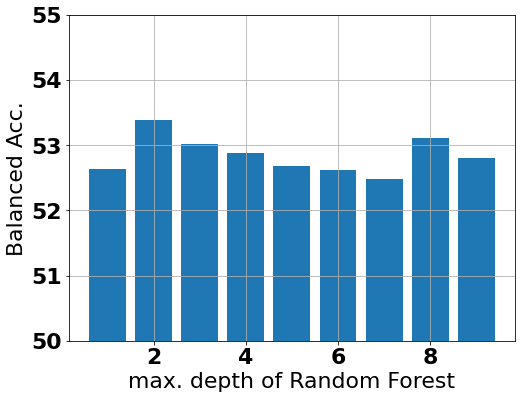

In [208]:
res = pd.concat(results).groupby('max_depth').mean()['ACC_BAL']
plt.bar(res.index, res.values)
plt.ylim([50,55])
plt.grid(True)
plt.ylabel('Balanced Acc.')
plt.xlabel('max. depth of Random Forest')

In [192]:
#results = pd.DataFrame({'max_depth':results.keys(),'bal_acc':results.values()})
results

,max_depth,bal_acc
0,9,52.845804


In [ ]:
results

In [182]:
pd.DataFrame(MEASUREMENTS).mean()

ACC          5.725156e+01
ACC_BAL      5.195078e+01
test_pid    2.028591e+274
dtype: float64

In [184]:
pd.DataFrame(MEASUREMENTS).mean()

ACC          5.711270e+01
ACC_BAL      5.224601e+01
test_pid    2.028591e+274
dtype: float64

In [177]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.100,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.500,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.03

- without selection

In [172]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GroupShuffleSplit
data = pd.merge(labels[['is_opportune_moment']],full_features, left_index=True, right_index=True)
str2num = {'receptive':1, 'non-receptive':0}
data['is_opportune_moment']=data['is_opportune_moment'].replace(str2num)


response_variable = 'is_opportune_moment'
feature_names = data.columns[~data.columns.str.contains(response_variable)].tolist()

MEASUREMENTS = []
pids = data.index.get_level_values('pid')
ss_outer = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=RANDOM_STATE)
for train_index, test_index in tqdm(ss_outer.split(data, groups=pids)):
    data_train = data.iloc[train_index]    
    data_test = data.iloc[test_index]
    
    #sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=RANDOM_STATE)
    sss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=RANDOM_STATE)
    
    for dev_index, val_index in sss.split(data_train,data_train[response_variable], groups=data_train.index.get_level_values('pid')):
        data_dev = data_train.iloc[dev_index]
        data_val = data_train.iloc[val_index]
        
    d_dev = catboost.Pool(
        data = data_dev[feature_names],
        label = data_dev[response_variable],
        feature_names = feature_names
    )

    d_val = catboost.Pool(
        data = data_val[feature_names],
        label = data_val[response_variable],
        feature_names = feature_names
    )

    clf = catboost.CatBoostClassifier(random_seed=RANDOM_STATE
                                     )    
    
    
    clf.fit(X = d_dev,
          use_best_model=True,
           eval_set = d_val,
           verbose_eval=False,
           early_stopping_rounds=20,
                plot=True
          )
            
    prob = clf.predict_proba(data_test[feature_names])[:,1]
    metrics = perf_metrics(data_test[response_variable], prob)    
    metrics['test_pid']=data.iloc[test_index].index.get_level_values('pid').unique().values[0]
    MEASUREMENTS.append(metrics)
pd.DataFrame(MEASUREMENTS).mean()

0it [00:00, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1it [00:00,  2.16it/s]


ACC           60.361613
ACC_BAL       56.506080
test_pid    1505.000000
dtype: float64

ACC           60.361613
ACC_BAL       56.506080
test_pid    1505.000000
dtype: float64

In [123]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.100,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.500,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.03

In [115]:
clf.get_best_iteration()

0

In [72]:
pd.DataFrame(MEASUREMENTS).mean()

ACC        58.404117
ACC_BAL    54.783090
dtype: float64

In [98]:
measure = run_classification(data.reset_index())

1    1961
0    1390
Name: is_opportune_moment, dtype: int64


2022-01-05 14:43:04,743	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
6it [00:00, 55.64it/s]

start conducting LOSO trials


76it [00:00, 82.61it/s]


(pid=22782) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22782) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22782) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22765) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22765) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22765) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22774) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22774) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22774) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22800) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22800) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22800) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=22773) Metr

In [54]:
measure.groupby('CV_TYPE').mean()

,ACC,ACC_BAL
CV_TYPE,,
LOSO,59.208086,52.943251


In [35]:
clf.fit(X = d_dev,
      use_best_model=True,
       eval_set = d_val,
       verbose_eval=False,
       early_stopping_rounds=200,
            plot=True
      )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Select features with corrleation

In [ ]:
multi_colliniearity_df = X.corr().sort_values('disturbance',key=abs, ascending=False).iloc[1:,1:]
multi_colliniearity_df.head()

excluded_features = get_colliniear_features(multi_colliniearity_df)


selected_features = list(set(multi_colliniearity_df.columns)-set(excluded_features) )
print(f'{len(selected_features)}  features are selected among {multi_colliniearity_df.shape[0]}:')

#### Group Inner Split

In [43]:
data = pd.merge(labels[['is_opportune_moment']],full_features[selected_features], left_index=True,right_index=True)
measure = run_classification(data.reset_index())

receptive        1961
non-receptive    1390
Name: is_opportune_moment, dtype: int64
np.unique(y, return_counts=True) =  (array([0, 1]), array([1390, 1961]))


2022-01-04 15:15:21,213	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
9it [00:00, 67.97it/s]

start conducting LOSO trials
trial #0 
 test_pid count:1541    85
Name: pid, dtype: int64
trial #1 
 test_pid count:729    83
Name: pid, dtype: int64
trial #2 
 test_pid count:1523    79
Name: pid, dtype: int64
trial #3 
 test_pid count:1521    77
Name: pid, dtype: int64
trial #4 
 test_pid count:727    76
Name: pid, dtype: int64
trial #5 
 test_pid count:3018    76
Name: pid, dtype: int64
trial #6 
 test_pid count:3010    73
Name: pid, dtype: int64
trial #7 
 test_pid count:3025    73
Name: pid, dtype: int64
trial #8 
 test_pid count:1516    71
Name: pid, dtype: int64
trial #9 
 test_pid count:1502    70
Name: pid, dtype: int64
trial #10 
 test_pid count:708    69
Name: pid, dtype: int64
trial #11 
 test_pid count:3027    65
Name: pid, dtype: int64


16it [00:00, 54.71it/s]

trial #12 
 test_pid count:3022    65
Name: pid, dtype: int64
trial #13 
 test_pid count:3016    65
Name: pid, dtype: int64
trial #14 
 test_pid count:1526    63
Name: pid, dtype: int64
trial #15 
 test_pid count:3009    61
Name: pid, dtype: int64
trial #16 
 test_pid count:1511    60
Name: pid, dtype: int64
trial #17 
 test_pid count:3005    57
Name: pid, dtype: int64
trial #18 
 test_pid count:1514    57
Name: pid, dtype: int64
trial #19 
 test_pid count:3002    56
Name: pid, dtype: int64
trial #20 
 test_pid count:709    55
Name: pid, dtype: int64
trial #21 
 test_pid count:1503    54
Name: pid, dtype: int64


27it [00:00, 41.04it/s]

trial #22 
 test_pid count:713    54
Name: pid, dtype: int64
trial #23 
 test_pid count:719    52
Name: pid, dtype: int64
trial #24 
 test_pid count:1504    52
Name: pid, dtype: int64
trial #25 
 test_pid count:3015    52
Name: pid, dtype: int64
trial #26 
 test_pid count:728    51
Name: pid, dtype: int64
trial #27 
 test_pid count:702    51
Name: pid, dtype: int64
trial #28 
 test_pid count:1507    51
Name: pid, dtype: int64


32it [00:00, 40.49it/s]

trial #29 
 test_pid count:705    51
Name: pid, dtype: int64
trial #30 
 test_pid count:722    50
Name: pid, dtype: int64
trial #31 
 test_pid count:3029    50
Name: pid, dtype: int64
trial #32 
 test_pid count:724    49
Name: pid, dtype: int64
trial #33 
 test_pid count:706    49
Name: pid, dtype: int64
trial #34 
 test_pid count:3041    47
Name: pid, dtype: int64
trial #35 
 test_pid count:710    47
Name: pid, dtype: int64
trial #36 
 test_pid count:712    45
Name: pid, dtype: int64


42it [00:00, 39.31it/s]

trial #37 
 test_pid count:3028    44
Name: pid, dtype: int64
trial #38 
 test_pid count:703    44
Name: pid, dtype: int64
trial #39 
 test_pid count:1527    43
Name: pid, dtype: int64
trial #40 
 test_pid count:1525    43
Name: pid, dtype: int64
trial #41 
 test_pid count:701    40
Name: pid, dtype: int64
trial #42 
 test_pid count:1505    39
Name: pid, dtype: int64
trial #43 
 test_pid count:1519    38
Name: pid, dtype: int64


51it [00:01, 38.74it/s]

trial #44 
 test_pid count:1522    37
Name: pid, dtype: int64
trial #45 
 test_pid count:3019    37
Name: pid, dtype: int64
trial #46 
 test_pid count:3030    36
Name: pid, dtype: int64
trial #47 
 test_pid count:704    34
Name: pid, dtype: int64
trial #48 
 test_pid count:1510    33
Name: pid, dtype: int64
trial #49 
 test_pid count:3012    33
Name: pid, dtype: int64
trial #50 
 test_pid count:3024    33
Name: pid, dtype: int64
trial #51 
 test_pid count:1501    32
Name: pid, dtype: int64
trial #52 
 test_pid count:718    32
Name: pid, dtype: int64
trial #53 
 test_pid count:721    31
Name: pid, dtype: int64


60it [00:01, 39.05it/s]

trial #54 
 test_pid count:3023    31
Name: pid, dtype: int64
trial #55 
 test_pid count:1515    31
Name: pid, dtype: int64
trial #56 
 test_pid count:3003    31
Name: pid, dtype: int64
trial #57 
 test_pid count:1509    31
Name: pid, dtype: int64
trial #58 
 test_pid count:3013    30
Name: pid, dtype: int64
trial #59 
 test_pid count:716    30
Name: pid, dtype: int64
trial #60 
 test_pid count:1508    29
Name: pid, dtype: int64
trial #61 
 test_pid count:3007    29
Name: pid, dtype: int64
trial #62 
 test_pid count:726    25
Name: pid, dtype: int64
trial #63 
 test_pid count:707    24
Name: pid, dtype: int64


71it [00:01, 42.40it/s]

trial #64 
 test_pid count:1517    24
Name: pid, dtype: int64
trial #65 
 test_pid count:1518    23
Name: pid, dtype: int64
trial #66 
 test_pid count:723    23
Name: pid, dtype: int64
trial #67 
 test_pid count:1506    22
Name: pid, dtype: int64
trial #68 
 test_pid count:711    22
Name: pid, dtype: int64
trial #69 
 test_pid count:3014    14
Name: pid, dtype: int64
trial #70 
 test_pid count:717    13
Name: pid, dtype: int64
trial #71 
 test_pid count:3001    13
Name: pid, dtype: int64
trial #72 
 test_pid count:714    11
Name: pid, dtype: int64


76it [00:01, 41.26it/s]


trial #73 
 test_pid count:3017    11
Name: pid, dtype: int64
trial #74 
 test_pid count:725    10
Name: pid, dtype: int64
trial #75 
 test_pid count:1520    4
Name: pid, dtype: int64
(pid=24049) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24076) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24043) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24058) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24061) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24061) 
(pid=23975) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24055) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=23988) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24079) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=24042) MetricVisualizer(layout=Layout(align_self='stretch', 

RayTaskError(NameError): [36mray::run_trial()[39m (pid=24048, ip=165.246.21.201)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "<ipython-input-2-62e1a89b54da>", line 156, in run_trial
NameError: name 'res' is not defined

In [667]:
measure.groupby('CV_TYPE').mean()

,ACC,ACC_BAL
CV_TYPE,,
LOSO,0.569172,0.518248


In [ ]:
0.582082	0.518148

#### Stratified Inner Split

In [23]:
full_features =pd.read_csv('features/FT_full-FW_6HR-SW_30MIN.csv', dtype={'pid':'str'}, parse_dates=['timestamp'])
full_features.set_index(['pid','timestamp'],inplace=True)
full_features.head()

appUsage_appPackage#6HR#ETP  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                     0.620475   
     2019-05-16 13:42:00                     0.778287   
     2019-05-16 14:25:00                     0.783193   
     2019-05-16 15:12:00                     0.719057   
     2019-05-16 16:39:00                     0.928423   

                          appUsage_appPackage#6HR#ASC  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                         62.0   
     2019-05-16 13:42:00                         92.0   
     2019-05-16 14:25:00                        122.0   
     2019-05-16 15:12:00                        135.0   
     2019-05-16 16:39:00                        171.0   

                          appUsage_appCategory#6HR#ETP  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                      0.536761   
     2019-05-16 13:42:00                      0.485847   
     2019-05-16 14:25:00                      0.501337   
     2019-05-16 15:12:00                      0.454799   
     2019-05-16 16:39:00                      0.602199   

                          appUsage_appCategory#6HR#ASC  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                          49.0   
     2019-05-16 13:42:00                          73.0   
     2019-05-16 14:25:00                          97.0   
     2019-05-16 15:12:00                         112.0   
     2019-05-16 16:39:00                         130.0   

                          appUsage_appCategory#6HR#SUP:Lifestyle  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.000607   
     2019-05-16 13:42:00                                0.000417   
     2019-05-16 14:25:00                                0.000361   
     2019-05-16 15:12:00                                0.003009   
     2019-05-16 16:39:00                                0.003611   

                          appUsage_appCategory#6HR#SUP:Productivity/Business  \
pid  timestamp                                                                 
1501 2019-05-16 12:14:00                                           0.000607    
     2019-05-16 13:42:00                                           0.000417    
     2019-05-16 14:25:00                                           0.000361    
     2019-05-16 15:12:00                                           0.000324    
     2019-05-16 16:39:00                                           0.001528    

                          appUsage_appCategory#6HR#SUP:Social/Communication  \
pid  timestamp                                                                
1501 2019-05-16 12:14:00                                           0.079493   
     2019-05-16 13:42:00                                           0.072963   
     2019-05-16 14:25:00                                           0.087293   
     2019-05-16 15:12:00                                           0.095741   
     2019-05-16 16:39:00                                           0.125278   

                          appUsage_appCategory#6HR#SUP:Tools  \
pid  timestamp                                                 
1501 2019-05-16 12:14:00                            0.070641   
     2019-05-16 13:42:00                            0.052610   
     2019-05-16 14:25:00                            0.047000   
     2019-05-16 15:12:00                            0.022083   
     2019-05-16 16:39:00                            0.042315   

                          appUsage_appCategory#6HR#SUP:UNDEFINED  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.848651   
     2019-05-16 13:42:00                                0.871392   
     2019-05-16 14:25:00                                0.863076   
     2019-05-16 15:12:00       

In [44]:
assert full_features.index.names==labels.index.names, 'should have same index for merging 2 DF'
X = pd.merge(labels[['disturbance']],full_features, left_index=True, right_index=True)


In [45]:
multi_colliniearity_df = X.corr().sort_values('disturbance',key=abs, ascending=False).iloc[1:,1:]
multi_colliniearity_df.head()

,appUsage_appPackage#6HR#ETP,appUsage_appPackage#6HR#ASC,appUsage_appCategory#6HR#ETP,appUsage_appCategory#6HR#ASC,appUsage_appCategory#6HR#SUP:Lifestyle,appUsage_appCategory#6HR#SUP:Productivity/Business,appUsage_appCategory#6HR#SUP:Social/Communication,appUsage_appCategory#6HR#SUP:Tools,appUsage_appCategory#6HR#SUP:UNDEFINED,battery_temperature#6HR#MED,...,activity_event#6HR#SUP:RUNNING,appUsage_appCategory#6HR#SUP:Health/Fitness,battery_status#6HR#SUP:NOT_CHARGING,appUsage_appCategory#6HR#SUP:Music/Audio,deviceEvent_event#6HR#SUP:RINGER_MODE_SILENT,bandUV_indexLevel#6HR#SUP:MEDIUM,deviceEvent_event#6HR#SUP:RINGER_MODE_NORMAL,deviceEvent_event#6HR#SUP:RINGER_MODE_VIBRATE,connection_type#6HR#SUP:MOBILE,appUsage_appCategory#6HR#SUP:Shopping
data_RX2TX#6HR#MAX,0.258675,0.245680,0.292513,0.242710,0.019494,0.074497,-0.048954,0.088387,-0.078769,0.098341,...,0.056219,-0.084366,-0.008822,0.087916,-0.057050,0.000534,-0.022186,0.043304,0.118291,0.048005
data_RX2TX#6HR#VAR,0.113626,0.096209,0.126883,0.118014,0.001549,0.068256,0.041565,0.052234,-0.057878,0.030800,...,0.097128,-0.030527,-0.012917,0.031834,-0.024377,0.018591,-0.008223,0.001865,0.065184,0.008722
data_RX2TX#6HR#ASC,0.509388,0.276075,0.524350,0.269205,0.047286,0.187577,0.198286,0.240978,-0.406951,0.262907,...,0.118167,-0.054890,0.006592,0.170855,-0.050602,0.003142,0.009876,0.114179,0.010435,0.156384
data_RX2TX#6HR#AVG,0.207796,0.082748,0.233455,0.107769,0.029856,0.088950,0.011720,0.084377,-0.126127,0.070817,...,0.069503,-0.041453,-0.014735,0.061673,-0.011266,0.058284,0.016477,0.013566,0.026145,0.054532
accelerometer_Y#6HR#AVG,-0.030016,-0.009764,-0.037989,0.006373,0.039042,0.037042,-0.049157,0.093133,0.014244,0.013655,...,0.006296,0.095529,0.055433,-0.030483,0.040537,-0.011675,-0.034067,-0.024554,0.051998,-0.015873


In [46]:
excluded_features = get_colliniear_features(multi_colliniearity_df)


selected_features = list(set(multi_colliniearity_df.columns)-set(excluded_features) )
print(f'{len(selected_features)}  features are selected among {multi_colliniearity_df.shape[0]}:')

180  features are selected among 424:


In [49]:
data = pd.merge(labels[['is_opportune_moment']],full_features[selected_features], left_index=True,right_index=True)
measure = run_classification(data.reset_index())

receptive        1961
non-receptive    1390
Name: is_opportune_moment, dtype: int64


2022-01-04 15:21:03,318	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
6it [00:00, 50.80it/s]

start conducting LOSO trials
trial #0 
 test_pid count:1541    85
Name: pid, dtype: int64
trial #1 
 test_pid count:729    83
Name: pid, dtype: int64
trial #2 
 test_pid count:1523    79
Name: pid, dtype: int64
trial #3 
 test_pid count:1521    77
Name: pid, dtype: int64
trial #4 
 test_pid count:727    76
Name: pid, dtype: int64
trial #5 
 test_pid count:3018    76
Name: pid, dtype: int64
trial #6 
 test_pid count:3010    73
Name: pid, dtype: int64
trial #7 
 test_pid count:3025    73
Name: pid, dtype: int64
trial #8 
 test_pid count:1516    71
Name: pid, dtype: int64
trial #9 
 test_pid count:1502    70
Name: pid, dtype: int64
trial #10 
 test_pid count:708    69
Name: pid, dtype: int64
trial #11 
 test_pid count:3027    65
Name: pid, dtype: int64
trial #12 
 test_pid count:3022    65
Name: pid, dtype: int64


24it [00:00, 79.53it/s]

trial #13 
 test_pid count:3016    65
Name: pid, dtype: int64
trial #14 
 test_pid count:1526    63
Name: pid, dtype: int64
trial #15 
 test_pid count:3009    61
Name: pid, dtype: int64
trial #16 
 test_pid count:1511    60
Name: pid, dtype: int64
trial #17 
 test_pid count:3005    57
Name: pid, dtype: int64
trial #18 
 test_pid count:1514    57
Name: pid, dtype: int64
trial #19 
 test_pid count:3002    56
Name: pid, dtype: int64
trial #20 
 test_pid count:709    55
Name: pid, dtype: int64
trial #21 
 test_pid count:1503    54
Name: pid, dtype: int64
trial #22 
 test_pid count:713    54
Name: pid, dtype: int64
trial #23 
 test_pid count:719    52
Name: pid, dtype: int64
trial #24 
 test_pid count:1504    52
Name: pid, dtype: int64
trial #25 
 test_pid count:3015    52
Name: pid, dtype: int64
trial #26 
 test_pid count:728    51
Name: pid, dtype: int64
trial #27 
 test_pid count:702    51
Name: pid, dtype: int64
trial #28 
 test_pid count:1507    51
Name: pid, dtype: int64
trial #29 
 t

47it [00:00, 98.26it/s]

trial #34 
 test_pid count:3041    47
Name: pid, dtype: int64
trial #35 
 test_pid count:710    47
Name: pid, dtype: int64
trial #36 
 test_pid count:712    45
Name: pid, dtype: int64
trial #37 
 test_pid count:3028    44
Name: pid, dtype: int64
trial #38 
 test_pid count:703    44
Name: pid, dtype: int64
trial #39 
 test_pid count:1527    43
Name: pid, dtype: int64
trial #40 
 test_pid count:1525    43
Name: pid, dtype: int64
trial #41 
 test_pid count:701    40
Name: pid, dtype: int64
trial #42 
 test_pid count:1505    39
Name: pid, dtype: int64
trial #43 
 test_pid count:1519    38
Name: pid, dtype: int64
trial #44 
 test_pid count:1522    37
Name: pid, dtype: int64
trial #45 
 test_pid count:3019    37
Name: pid, dtype: int64
trial #46 
 test_pid count:3030    36
Name: pid, dtype: int64
trial #47 
 test_pid count:704    34
Name: pid, dtype: int64
trial #48 
 test_pid count:1510    33
Name: pid, dtype: int64
trial #49 
 test_pid count:3012    33
Name: pid, dtype: int64
trial #50 
 t

76it [00:00, 98.09it/s] 

trial #57 
 test_pid count:1509    31
Name: pid, dtype: int64
trial #58 
 test_pid count:3013    30
Name: pid, dtype: int64
trial #59 
 test_pid count:716    30
Name: pid, dtype: int64
trial #60 
 test_pid count:1508    29
Name: pid, dtype: int64
trial #61 
 test_pid count:3007    29
Name: pid, dtype: int64
trial #62 
 test_pid count:726    25
Name: pid, dtype: int64
trial #63 
 test_pid count:707    24
Name: pid, dtype: int64
trial #64 
 test_pid count:1517    24
Name: pid, dtype: int64
trial #65 
 test_pid count:1518    23
Name: pid, dtype: int64
trial #66 
 test_pid count:723    23
Name: pid, dtype: int64
trial #67 
 test_pid count:1506    22
Name: pid, dtype: int64
trial #68 
 test_pid count:711    22
Name: pid, dtype: int64
trial #69 
 test_pid count:3014    14
Name: pid, dtype: int64
trial #70 
 test_pid count:717    13
Name: pid, dtype: int64
trial #71 
 test_pid count:3001    13
Name: pid, dtype: int64
trial #72 
 test_pid count:714    11
Name: pid, dtype: int64
trial #73 
 tes

(pid=30022) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=30022) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=30022) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29989) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29989) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29989) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29992) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29992) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29992) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=30020) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=30020) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=30020) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=29997) Metr

In [50]:
measure.groupby('CV_TYPE').mean()

,ACC,ACC_BAL
CV_TYPE,,
LOSO,0.582082,0.518148


#### Balancing

In [64]:
measure = run_classification(data.reset_index(), balance=True)
measure.groupby('CV_TYPE').mean()

receptive        1961
non-receptive    1390
Name: is_opportune_moment, dtype: int64


2022-01-04 16:03:18,251	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
8it [00:00, 77.57it/s]

start conducting LOSO trials
trial #0 
 test_pid count:1541    85
Name: pid, dtype: int64
trial #1 
 test_pid count:729    83
Name: pid, dtype: int64
trial #2 
 test_pid count:1523    79
Name: pid, dtype: int64
trial #3 
 test_pid count:1521    77
Name: pid, dtype: int64
trial #4 
 test_pid count:727    76
Name: pid, dtype: int64
trial #5 
 test_pid count:3018    76
Name: pid, dtype: int64
trial #6 
 test_pid count:3010    73
Name: pid, dtype: int64
trial #7 
 test_pid count:3025    73
Name: pid, dtype: int64
trial #8 
 test_pid count:1516    71
Name: pid, dtype: int64
trial #9 
 test_pid count:1502    70
Name: pid, dtype: int64
trial #10 
 test_pid count:708    69
Name: pid, dtype: int64
trial #11 
 test_pid count:3027    65
Name: pid, dtype: int64
trial #12 
 test_pid count:3022    65
Name: pid, dtype: int64
trial #13 
 test_pid count:3016    65
Name: pid, dtype: int64
trial #14 
 test_pid count:1526    63
Name: pid, dtype: int64
trial #15 
 test_pid count:3009    61
Name: pid, dtype

30it [00:00, 97.83it/s]

trial #18 
 test_pid count:1514    57
Name: pid, dtype: int64
trial #19 
 test_pid count:3002    56
Name: pid, dtype: int64
trial #20 
 test_pid count:709    55
Name: pid, dtype: int64
trial #21 
 test_pid count:1503    54
Name: pid, dtype: int64
trial #22 
 test_pid count:713    54
Name: pid, dtype: int64
trial #23 
 test_pid count:719    52
Name: pid, dtype: int64
trial #24 
 test_pid count:1504    52
Name: pid, dtype: int64
trial #25 
 test_pid count:3015    52
Name: pid, dtype: int64
trial #26 
 test_pid count:728    51
Name: pid, dtype: int64
trial #27 
 test_pid count:702    51
Name: pid, dtype: int64
trial #28 
 test_pid count:1507    51
Name: pid, dtype: int64
trial #29 
 test_pid count:705    51
Name: pid, dtype: int64
trial #30 
 test_pid count:722    50
Name: pid, dtype: int64
trial #31 
 test_pid count:3029    50
Name: pid, dtype: int64
trial #32 
 test_pid count:724    49
Name: pid, dtype: int64
trial #33 
 test_pid count:706    49
Name: pid, dtype: int64
trial #34 
 test_

53it [00:00, 106.43it/s]

trial #39 
 test_pid count:1527    43
Name: pid, dtype: int64
trial #40 
 test_pid count:1525    43
Name: pid, dtype: int64
trial #41 
 test_pid count:701    40
Name: pid, dtype: int64
trial #42 
 test_pid count:1505    39
Name: pid, dtype: int64
trial #43 
 test_pid count:1519    38
Name: pid, dtype: int64
trial #44 
 test_pid count:1522    37
Name: pid, dtype: int64
trial #45 
 test_pid count:3019    37
Name: pid, dtype: int64
trial #46 
 test_pid count:3030    36
Name: pid, dtype: int64
trial #47 
 test_pid count:704    34
Name: pid, dtype: int64
trial #48 
 test_pid count:1510    33
Name: pid, dtype: int64
trial #49 
 test_pid count:3012    33
Name: pid, dtype: int64
trial #50 
 test_pid count:3024    33
Name: pid, dtype: int64
trial #51 
 test_pid count:1501    32
Name: pid, dtype: int64
trial #52 
 test_pid count:718    32
Name: pid, dtype: int64
trial #53 
 test_pid count:721    31
Name: pid, dtype: int64
trial #54 
 test_pid count:3023    31
Name: pid, dtype: int64
trial #55 
 

76it [00:00, 107.36it/s]


trial #65 
 test_pid count:1518    23
Name: pid, dtype: int64
trial #66 
 test_pid count:723    23
Name: pid, dtype: int64
trial #67 
 test_pid count:1506    22
Name: pid, dtype: int64
trial #68 
 test_pid count:711    22
Name: pid, dtype: int64
trial #69 
 test_pid count:3014    14
Name: pid, dtype: int64
trial #70 
 test_pid count:717    13
Name: pid, dtype: int64
trial #71 
 test_pid count:3001    13
Name: pid, dtype: int64
trial #72 
 test_pid count:714    11
Name: pid, dtype: int64
trial #73 
 test_pid count:3017    11
Name: pid, dtype: int64
trial #74 
 test_pid count:725    10
Name: pid, dtype: int64
trial #75 
 test_pid count:1520    4
Name: pid, dtype: int64
(pid=2677) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=2677) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=2677) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=2677) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


,ACC,ACC_BAL
CV_TYPE,,
LOSO,0.535031,0.514267


- balance both dev/val

In [66]:
measure = run_classification(data.reset_index(), balance=True)
measure.groupby('CV_TYPE').mean()

receptive        1961
non-receptive    1390
Name: is_opportune_moment, dtype: int64


2022-01-04 16:14:57,621	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
8it [00:00, 65.38it/s]

start conducting LOSO trials
trial #0 
 test_pid count:1541    85
Name: pid, dtype: int64
trial #1 
 test_pid count:729    83
Name: pid, dtype: int64
trial #2 
 test_pid count:1523    79
Name: pid, dtype: int64
trial #3 
 test_pid count:1521    77
Name: pid, dtype: int64
trial #4 
 test_pid count:727    76
Name: pid, dtype: int64
trial #5 
 test_pid count:3018    76
Name: pid, dtype: int64
trial #6 
 test_pid count:3010    73
Name: pid, dtype: int64
trial #7 
 test_pid count:3025    73
Name: pid, dtype: int64
trial #8 
 test_pid count:1516    71
Name: pid, dtype: int64
trial #9 
 test_pid count:1502    70
Name: pid, dtype: int64
trial #10 
 test_pid count:708    69
Name: pid, dtype: int64
trial #11 
 test_pid count:3027    65
Name: pid, dtype: int64
trial #12 
 test_pid count:3022    65
Name: pid, dtype: int64
trial #13 
 test_pid count:3016    65
Name: pid, dtype: int64
trial #14 
 test_pid count:1526    63
Name: pid, dtype: int64
trial #15 
 test_pid count:3009    61
Name: pid, dtype

27it [00:00, 82.54it/s]

trial #16 
 test_pid count:1511    60
Name: pid, dtype: int64
trial #17 
 test_pid count:3005    57
Name: pid, dtype: int64
trial #18 
 test_pid count:1514    57
Name: pid, dtype: int64
trial #19 
 test_pid count:3002    56
Name: pid, dtype: int64
trial #20 
 test_pid count:709    55
Name: pid, dtype: int64
trial #21 
 test_pid count:1503    54
Name: pid, dtype: int64
trial #22 
 test_pid count:713    54
Name: pid, dtype: int64
trial #23 
 test_pid count:719    52
Name: pid, dtype: int64
trial #24 
 test_pid count:1504    52
Name: pid, dtype: int64
trial #25 
 test_pid count:3015    52
Name: pid, dtype: int64
trial #26 
 test_pid count:728    51
Name: pid, dtype: int64
trial #27 
 test_pid count:702    51
Name: pid, dtype: int64
trial #28 
 test_pid count:1507    51
Name: pid, dtype: int64
trial #29 
 test_pid count:705    51
Name: pid, dtype: int64
trial #30 
 test_pid count:722    50
Name: pid, dtype: int64
trial #31 
 test_pid count:3029    50
Name: pid, dtype: int64
trial #32 
 tes

48it [00:00, 91.89it/s]

trial #34 
 test_pid count:3041    47
Name: pid, dtype: int64
trial #35 
 test_pid count:710    47
Name: pid, dtype: int64
trial #36 
 test_pid count:712    45
Name: pid, dtype: int64
trial #37 
 test_pid count:3028    44
Name: pid, dtype: int64
trial #38 
 test_pid count:703    44
Name: pid, dtype: int64
trial #39 
 test_pid count:1527    43
Name: pid, dtype: int64
trial #40 
 test_pid count:1525    43
Name: pid, dtype: int64
trial #41 
 test_pid count:701    40
Name: pid, dtype: int64
trial #42 
 test_pid count:1505    39
Name: pid, dtype: int64
trial #43 
 test_pid count:1519    38
Name: pid, dtype: int64
trial #44 
 test_pid count:1522    37
Name: pid, dtype: int64
trial #45 
 test_pid count:3019    37
Name: pid, dtype: int64
trial #46 
 test_pid count:3030    36
Name: pid, dtype: int64
trial #47 
 test_pid count:704    34
Name: pid, dtype: int64
trial #48 
 test_pid count:1510    33
Name: pid, dtype: int64
trial #49 
 test_pid count:3012    33
Name: pid, dtype: int64
trial #50 
 t

76it [00:00, 93.38it/s] 

trial #56 
 test_pid count:3003    31
Name: pid, dtype: int64
trial #57 
 test_pid count:1509    31
Name: pid, dtype: int64
trial #58 
 test_pid count:3013    30
Name: pid, dtype: int64
trial #59 
 test_pid count:716    30
Name: pid, dtype: int64
trial #60 
 test_pid count:1508    29
Name: pid, dtype: int64
trial #61 
 test_pid count:3007    29
Name: pid, dtype: int64
trial #62 
 test_pid count:726    25
Name: pid, dtype: int64
trial #63 
 test_pid count:707    24
Name: pid, dtype: int64
trial #64 
 test_pid count:1517    24
Name: pid, dtype: int64
trial #65 
 test_pid count:1518    23
Name: pid, dtype: int64
trial #66 
 test_pid count:723    23
Name: pid, dtype: int64
trial #67 
 test_pid count:1506    22
Name: pid, dtype: int64
trial #68 
 test_pid count:711    22
Name: pid, dtype: int64
trial #69 
 test_pid count:3014    14
Name: pid, dtype: int64
trial #70 
 test_pid count:717    13
Name: pid, dtype: int64
trial #71 
 test_pid count:3001    13
Name: pid, dtype: int64
trial #72 
 te

(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8663) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8640) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=8640) MetricVisualizer(

,ACC,ACC_BAL
CV_TYPE,,
LOSO,0.525528,0.502049


#### Feature Selection Experiment

In [9]:
full_features =pd.read_csv('features/FT_full-FW_6HR-SW_30MIN.csv', dtype={'pid':'str'}, parse_dates=['timestamp'])
full_features.set_index(['pid','timestamp'],inplace=True)
full_features = drop_zero_varience_features(full_features)

full_features_norm = participant_wise_normalization(full_features)
full_features_norm.head()

  0%|          | 0/76 [00:00<?, ?it/s]

Participant-level Min/Max normalization...


100%|██████████| 76/76 [00:05<00:00, 12.93it/s]


appUsage_appPackage#6HR#ETP  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                     0.152192   
     2019-05-16 13:42:00                     0.279281   
     2019-05-16 14:25:00                     0.283232   
     2019-05-16 15:12:00                     0.231582   
     2019-05-16 16:39:00                     0.400187   

                          appUsage_appPackage#6HR#ASC  \
pid  timestamp                                          
1501 2019-05-16 12:14:00                     0.098592   
     2019-05-16 13:42:00                     0.204225   
     2019-05-16 14:25:00                     0.309859   
     2019-05-16 15:12:00                     0.355634   
     2019-05-16 16:39:00                     0.482394   

                          appUsage_appCategory#6HR#ETP  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                      0.280365   
     2019-05-16 13:42:00                      0.233398   
     2019-05-16 14:25:00                      0.247688   
     2019-05-16 15:12:00                      0.204758   
     2019-05-16 16:39:00                      0.340729   

                          appUsage_appCategory#6HR#ASC  \
pid  timestamp                                           
1501 2019-05-16 12:14:00                      0.095023   
     2019-05-16 13:42:00                      0.203620   
     2019-05-16 14:25:00                      0.312217   
     2019-05-16 15:12:00                      0.380090   
     2019-05-16 16:39:00                      0.461538   

                          appUsage_appCategory#6HR#SUP:Lifestyle  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.012309   
     2019-05-16 13:42:00                                0.008441   
     2019-05-16 14:25:00                                0.007318   
     2019-05-16 15:12:00                                0.060976   
     2019-05-16 16:39:00                                0.073171   

                          appUsage_appCategory#6HR#SUP:Productivity/Business  \
pid  timestamp                                                                 
1501 2019-05-16 12:14:00                                           0.030445    
     2019-05-16 13:42:00                                           0.020878    
     2019-05-16 14:25:00                                           0.018099    
     2019-05-16 15:12:00                                           0.016241    
     2019-05-16 16:39:00                                           0.076566    

                          appUsage_appCategory#6HR#SUP:Social/Communication  \
pid  timestamp                                                                
1501 2019-05-16 12:14:00                                           0.123201   
     2019-05-16 13:42:00                                           0.100277   
     2019-05-16 14:25:00                                           0.150582   
     2019-05-16 15:12:00                                           0.180237   
     2019-05-16 16:39:00                                           0.283927   

                          appUsage_appCategory#6HR#SUP:Tools  \
pid  timestamp                                                 
1501 2019-05-16 12:14:00                            0.563650   
     2019-05-16 13:42:00                            0.406600   
     2019-05-16 14:25:00                            0.357741   
     2019-05-16 15:12:00                            0.140726   
     2019-05-16 16:39:00                            0.316935   

                          appUsage_appCategory#6HR#SUP:UNDEFINED  \
pid  timestamp                                                     
1501 2019-05-16 12:14:00                                0.794339   
     2019-05-16 13:42:00                                0.842998   
     2019-05-16 14:25:00                                0.825204   
     2019-05-16 15:12:00       

##### With Variance Threshold
https://scikit-learn.org/stable/modules/feature_selection.html

In [8]:
STD_THRESHOLD = 1

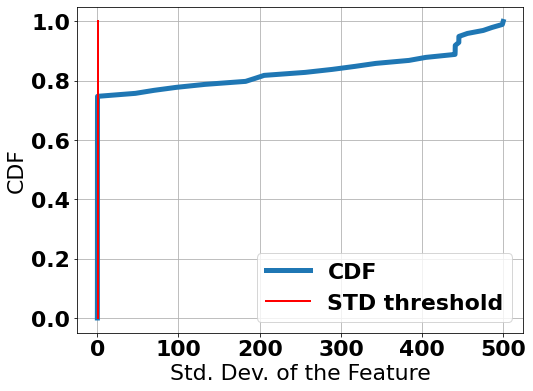

In [13]:
ds = full_features_norm.std().sort_values()
I = np.linspace(0,1,100)
plt.plot(ds.quantile(I),I, linewidth=5, label='CDF')
plt.plot([STD_THRESHOLD, STD_THRESHOLD],[0,1], color='red', linewidth=2, label='STD threshold')
plt.ylabel('CDF')
plt.xlabel('Std. Dev. of the Feature')
plt.grid(True)
plt.legend()

- how many percentage features are exc. with the given STD_THRESHOLD

In [21]:
len(ds[ds<STD_THRESHOLD])/len(ds)*TO_PERCENTAGE


75.236

In [22]:
small_varience_features = ds[ds<1].index.tolist()
selected_features = list(set(full_features_norm.columns.tolist())-set(small_varience_features))
f'with variance threshold of {STD_THRESHOLD}, {len(selected_features)}/{full_features_norm.shape[1]} features are selected'

'with variance threshold of 1, 105/424 features are selected'

- with normalization

In [23]:
data = pd.merge(labels[['is_opportune_moment']],full_features_norm[selected_features], left_index=True,right_index=True)
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean().round(decimals=3)

receptive        1961
non-receptive    1390
Name: is_opportune_moment, dtype: int64


2022-01-05 11:01:42,373	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
16it [00:00, 154.44it/s]

start conducting LOSO trials


76it [00:00, 151.90it/s]


(pid=32735) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32724) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32732) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32733) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32736) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32788) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32782) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32731) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32787) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32729) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32814) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32784) MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
(pid=32786) Metr

,ACC,ACC_BAL
CV_TYPE,,
LOSO,56.023,52.713


- Recursive feature elimination

In [ ]:
data = pd.merge(labels['is_opportune_moment'], full_features, left_index=True, right_index=True)
X = data.iloc[:,~data.columns.str.contains('is_opportune_moment')]
X = participant_wise_normalization(X)
X.head()

In [20]:
pids = X.index.get_level_values('pid').to_list()

In [14]:
y = np.where(data['is_opportune_moment']=='receptive',1,0)
y

array([1, 1, 1, ..., 0, 0, 1])

In [22]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

In [24]:
np.array(X)

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0],
       [0, 1, 1]])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X.iloc, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

### Extended Features

In [391]:
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        extended_features = dataset.parallellize_extract_extended(
            labels=labels, 
            use_ray=True
        )


2022-01-07 10:44:24,133	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265

100%|██████████| 76/76 [09:27<00:00,  7.47s/it]


In [392]:
extended_features[extended_features['appUsage_appCategory#CUR#VAL'].isnull()]

appUsage_appCategory#CUR#VAL  \
pid  timestamp                                          
1510 2019-05-16 10:09:00                          NaN   
     2019-05-16 11:17:00                          NaN   
     2019-05-16 12:56:00                          NaN   
3023 2019-04-30 14:25:00                          NaN   
     2019-04-30 16:44:00                          NaN   
     2019-04-30 18:53:00                          NaN   
     2019-04-30 20:22:00                          NaN   
     2019-05-01 16:35:00                          NaN   
     2019-05-01 18:07:00                          NaN   
     2019-05-01 19:39:00                          NaN   
     2019-05-01 21:14:00                          NaN   
     2019-05-01 21:57:00                          NaN   
     2019-05-02 11:24:00                          NaN   
     2019-05-02 13:40:00                          NaN   
     2019-05-02 14:25:00                          NaN   
     2019-05-02 16:44:00                          NaN   
     2019-05-02 18:54:00                          NaN   
     2019-05-03 12:54:00                          NaN   
     2019-05-03 14:24:00                          NaN   
     2019-05-03 15:46:00                          NaN   
     2019-05-03 18:52:00                          NaN   

                          battery_temperature#CUR#VAL  battery_level#CUR#VAL  \
pid  timestamp                                                                 
1510 2019-05-16 10:09:00                          NaN                    NaN   
     2019-05-16 11:17:00                          NaN                    NaN   
     2019-05-16 12:56:00                          NaN                    NaN   
3023 2019-04-30 14:25:00                          NaN                    NaN   
     2019-04-30 16:44:00                          NaN                    NaN   
     2019-04-30 18:53:00                          NaN                    NaN   
     2019-04-30 20:22:00                          NaN                    NaN   
     2019-05-01 16:35:00                          NaN                    NaN   
     2019-05-01 18:07:00                          NaN                    NaN   
     2019-05-01 19:39:00                          NaN                    NaN   
     2019-05-01 21:14:00                          NaN                    NaN   
     2019-05-01 21:57:00                          NaN                    NaN   
     2019-05-02 11:24:00                          NaN                    NaN   
     2019-05-02 13:40:00                          NaN                    NaN   
     2019-05-02 14:25:00                          NaN                    NaN   
     2019-05-02 16:44:00                          NaN                    NaN   
     2019-05-02 18:54:00                          NaN                    NaN   
     2019-05-03 12:54:00                          NaN                    NaN   
     2019-05-03 14:24:00                          NaN                    NaN   
     2019-05-03 15:46:00                          NaN                    NaN   
     2019-05-03 18:52:00                          NaN                    NaN   

                         battery_plugState#CUR#VAL battery_status#CUR#VAL  \
pid  timestamp                                                              
1510 2019-05-16 10:09:00                       NaN                    NaN   
     2019-05-16 11:17:00                       NaN                    NaN   
     2019-05-16 12:56:00                       NaN                    NaN   
3023 2019-04-30 14:25:00                       NaN                    NaN   
     2019-04-30 16:44:00                       NaN                    NaN   
     2019-04-30 18:53:00                       NaN                    NaN   
     2019-04-30 20:22:00                       NaN                    NaN   
     2019-05-01 16:35:00                       NaN                    NaN   
     2019-05-01 18:07:00                       NaN                    NaN   
     2019-05-01 19:39:00 

In [386]:
pd.read_csv('data/app_category.csv').abstract.value_counts()

Tools                    182
Lifestyle                 86
Media/Entertainment       85
Productivity/Business     79
Finance                   68
Travel                    52
Social/Communication      41
Shopping                  39
Photography               29
Music/Audio               24
Health/Fitness            23
Name: abstract, dtype: int64

In [399]:
app_usage = dataset._load_app_usage('1510')
app_usage['appUsage_appCategory'].isnull().sum()

654

Timestamp('2019-05-22 13:29:00')

In [415]:
res = dataset._resample(app_usage['appUsage_appCategory'], labels.loc['1510'].index.max())
res

timestamp
2019-05-16 15:53:54    UNDEFINED
2019-05-16 15:53:55        Tools
2019-05-16 15:53:56        Tools
2019-05-16 15:53:57        Tools
2019-05-16 15:53:58        Tools
                         ...    
2019-05-23 02:30:07    UNDEFINED
2019-05-23 02:30:08    UNDEFINED
2019-05-23 02:30:09    UNDEFINED
2019-05-23 02:30:10    UNDEFINED
2019-05-23 02:30:11    UNDEFINED
Freq: S, Name: event, Length: 556578, dtype: object

In [414]:
labels.loc['1510'].shape

(33, 21)

In [421]:
res[:pd.to_datetime('2019-05-16 10:09:00')]

Series([], Freq: S, Name: event, dtype: object)

In [422]:
res.index.min()

Timestamp('2019-05-16 15:53:54', freq='S')

In [416]:
m = pd.merge(res, labels.loc['1510'], left_index=True, right_index=True)
m.shape

(30, 22)

In [419]:
m.event.isnull().sum()

0

In [404]:
app_usage['appUsage_appCategory'].isnull().sum()

654

In [397]:
app_usage['appUsage_appCategory'].isnull().sum()

654

In [398]:
app_usage['appUsage_appCategory'].isnull().sum()

654

dict_keys(['appUsage_appPackage', 'appUsage_appCategory'])

In [378]:
app_usage_resampled = {}
app_usage_resampled['appUsage_appPackage'] = dataset._resample(app_usage['appUsage_appPackage'])

In [381]:
app_usage_resampled['appUsage_appPackage']

timestamp
2019-05-16 15:53:54                       UNDEFINED
2019-05-16 15:53:55    com.samsung.android.incallui
2019-05-16 15:53:56    com.samsung.android.incallui
2019-05-16 15:53:57    com.samsung.android.incallui
2019-05-16 15:53:58    com.samsung.android.incallui
                                   ...             
2019-05-23 02:30:07                       UNDEFINED
2019-05-23 02:30:08                       UNDEFINED
2019-05-23 02:30:09                       UNDEFINED
2019-05-23 02:30:10                       UNDEFINED
2019-05-23 02:30:11                       UNDEFINED
Freq: S, Name: event, Length: 556578, dtype: object

## Data Split

In [10]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(
    join(DATAROOT,'binned_esm_data.csv'), 
    dtype=LABEL_DTYPES,
    parse_dates=['timestamp']
).set_index(['pid','timestamp'])

pids = labels.index.get_level_values('pid').unique().tolist()
N = len(pids)
r = .5 # rule mining pariticpants ratio
arm_pids = pids[:int(N*r)]

labels_arm = labels[labels.index.get_level_values('pid').isin(arm_pids)]
labels_ml = labels[~labels.index.get_level_values('pid').isin(arm_pids)]
labels_arm.shape, labels_ml.shape

((1580, 20), (1754, 20))

In [11]:
labels_arm.index.get_level_values('pid').nunique()

36

In [12]:
labels_ml.index.get_level_values('pid').nunique()

37

## RuleGenerateSet


In [11]:
labels_arm.receptivity.value_counts()

receptive        913
non-receptive    667
Name: receptivity, dtype: int64

In [29]:

print(f'num of interventions: {labels_arm.shape[0]}')
num_participants = labels_arm.index.get_level_values('pid').nunique()


sub_winsize = 20 # min
print('number of sub-windows (transactions) for the given feature:\n num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize')
num_participants*utils.COLLECTION_DAYS*utils.COLLECTION_HOURS*utils.MIN_IN_HOUR//sub_winsize

num of interventions: 1580
number of sub-windows (transactions) for the given feature:
 num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize


9072

### Select window size
- which window size
    - 40  MIN
    - 80  MIN
    

- how many sub window size
    - 2
    - 4
    - 8

In [12]:
sub_features_d={}
windows = {
    '40MIN': 40 * 60
    ,'80MIN': 80 * 60
    ,'160MIN': 160 * 60
}
num_sub_windows = [2,4,8]


#### Extract sub features

In [ ]:
with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    for i,nsub in enumerate(num_sub_windows):
        for window_name, window_size  in windows.items():
            print(f'{window_name} at {nsub} subwindows')
            sub_features = dataset.parallellize_extract_sub(
                labels=labels_arm, 
                w_name=window_name,
                w_size = window_size,
                use_ray=True
                ,num_sub=nsub
            )
            sub_features.to_csv(f'feature/arm/{window_name}_{nsub}.csv')
            sub_features_d[(nsub,window_name)]=sub_features

#### plot missing features

40MIN,2: 7.57848101265823
40MIN,4: 7.3566455696202535
40MIN,8: 7.233544303797468
80MIN,2: 9.00759493670886
80MIN,4: 8.495886075949366
80MIN,8: 8.22246835443038
160MIN,2: 12.80284810126582
160MIN,4: 11.549208860759494
160MIN,8: 11.0309335443038


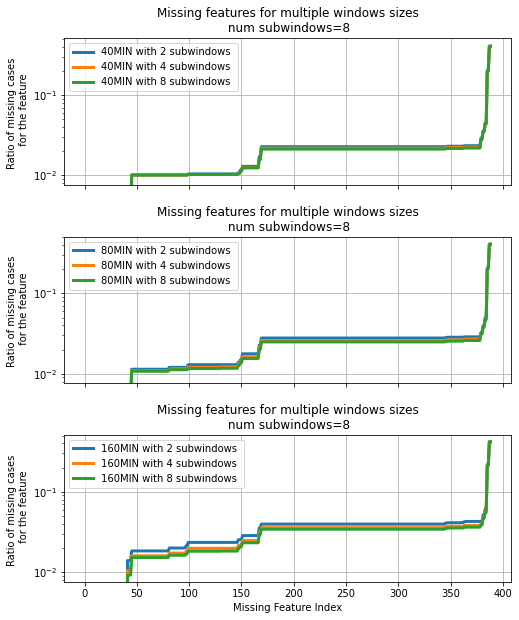

In [23]:


from feature_preprocessing import impute_support_features


fig, axes = plt.subplots(nrows=len(num_sub_windows),ncols=1, figsize=(8,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.35)
measurement = pd.DataFrame(columns=['window size','number of subwindows','missing features for single sample (on avg.)'])
with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    for i, (window_name, window_size) in enumerate(windows.items()):
        ax = axes[i]
        for _ ,nsub in enumerate(num_sub_windows):
        
            sub_features = pd.read_csv(
                f'feature/arm/{window_name}_{nsub}.csv'
            ).set_index(['pid','timestamp','sub_timestamp']) #sub_features_d[(nsub,window_name)]
            sub_features = impute_support_features(sub_features)
            ds = sub_features.isnull().sum(axis=0).sort_values(ascending=True).values            
            #ds = ds[ds>len(sub_features)/100*20]/(len(sub_features))
            ds = ds/(len(sub_features))
            print(f'{window_name},{nsub}: {ds.sum()}')
            measurement = pd.concat(
                [
                    measurement
                    ,pd.DataFrame(
                        {
                            'window size':[window_name]
                            ,'number of subwindows':[nsub]
                            ,'missing features for single sample (on avg.)':[ds.sum()]
                        }                    
                    )
                ]
                , ignore_index=True
                
            )
            ax.plot(ds, label=f'{window_name} with {nsub} subwindows ', linewidth=3)
            ax.set_yscale('log')
        ax.set_ylabel('Ratio of missing cases \n for the feature')    
        
        ax.grid(True)
        ax.legend()
        ax.set_title(f'Missing features for multiple windows sizes\n num subwindows={nsub}')
        
plt.xlabel('Missing Feature Index')
plt.show()


In [27]:
pd.set_option("display.precision", 2)
measurement.to_csv(f'setting/missing_feature_for_each_combinations.csv', index=False)
measurement

,window size,number of subwindows,missing features for single sample (on avg.)
0,40MIN,2,7.58
1,40MIN,4,7.36
2,40MIN,8,7.23
3,80MIN,2,9.01
4,80MIN,4,8.50
5,80MIN,8,8.22
6,160MIN,2,12.80
7,160MIN,4,11.55
8,160MIN,8,11.03


### aggregated features 
#### compute

In [116]:
window_name, nsub = '80MIN', 4
sub_features = pd.read_csv(
    f'feature/arm/{window_name}_{nsub}.csv'
    ,dtype={'pid':str}
    ,parse_dates=['timestamp','sub_timestamp']
).set_index(['pid','timestamp','sub_timestamp'])

from feature_preprocessing import *

sub_features = impute_support_features(
        normalization(sub_features)
)


agg_feature = sub_features.groupby(['pid','timestamp']).agg(
    ['mean','std']
)
agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
agg_feature

appUsage_appPackage#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.02   
     2019-05-16 13:46:27                                      0.23   
     2019-05-16 14:28:19                                      0.12   
     2019-05-16 15:12:59                                      0.18   
     2019-05-16 16:41:48                                      0.50   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.44   
     2019-05-14 18:54:15                                      0.46   
     2019-05-14 19:33:13                                      0.48   
     2019-05-14 20:16:19                                      0.59   
     2019-05-14 21:02:23                                      0.40   

                          appUsage_appPackage#80MIN#20MIN#ETP|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.03   
     2019-05-16 13:46:27                                     0.20   
     2019-05-16 14:28:19                                     0.19   
     2019-05-16 15:12:59                                     0.28   
     2019-05-16 16:41:48                                     0.10   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.17   
     2019-05-14 18:54:15                                     0.20   
     2019-05-14 19:33:13                                     0.17   
     2019-05-14 20:16:19                                     0.11   
     2019-05-14 21:02:23                                     0.23   

                          appUsage_appPackage#80MIN#20MIN#ASC|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.01   
     2019-05-16 13:46:27                                      0.07   
     2019-05-16 14:28:19                                      0.04   
     2019-05-16 15:12:59                                      0.10   
     2019-05-16 16:41:48                                      0.15   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.14   
     2019-05-14 18:54:15                                      0.17   
     2019-05-14 19:33:13                                      0.12   
     2019-05-14 20:16:19                                      0.18   
     2019-05-14 21:02:23                                      0.15   

                          appUsage_appPackage#80MIN#20MIN#ASC|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.02   
     2019-05-16 13:46:27                                     0.06   
     2019-05-16 14:28:19                                     0.05   
     2019-05-16 15:12:59                                     0.13   
     2019-05-16 16:41:48                                     0.04   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.07   
     2019-05-14 18:54:15                                     0.10   
     2019-05-14 19:33:13                                     0.07   
     2019-05-14 20:16:19                                     0.05   
     2019-05-14 21:02:23                                     0.10   

                          appUsage_appCategory#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                        
1501 2019-05-16 12:17:02                                       0.02   
     2019-05-16 13:46:27                                       0.16   
     2019-05-16 14:28:19                                       0.13   
     2019-05-16 15:12:59                             

#### Feature selection

##### missing count thresholding

Text(150, 0.25, 'Cut off threshold\n for missing feature count')

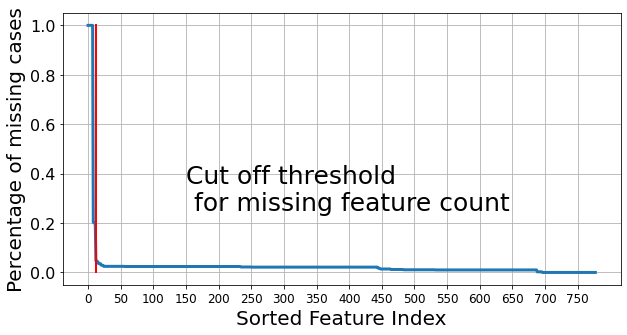

In [117]:
ds_missing = agg_feature.isnull().sum(axis=0)/len(agg_feature)
#thresholding
agg_feature_percent_missing  = agg_feature.loc[:,(ds_missing[ds_missing<.2]).index]

plt.figure(figsize=(10,5))
N, D = agg_feature.shape
ds_missing.sort_values(ascending=False).plot(linewidth=3)
I = np.arange(0,D,50)
plt.xticks(I,I, fontsize=12);
plt.yticks( fontsize=16);
plt.grid()
plt.xlabel('Sorted Feature Index', fontsize=20)
plt.ylabel('Percentage of missing cases', fontsize=20)
plt.plot([12,12],[0,1], color='red',linewidth=2)

plt.text(150,0.25,'Cut off threshold\n for missing feature count', fontsize=25)

In [83]:
agg_feature_percent_missing

appUsage_appPackage#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.02   
     2019-05-16 13:46:27                                      0.23   
     2019-05-16 14:28:19                                      0.12   
     2019-05-16 15:12:59                                      0.18   
     2019-05-16 16:41:48                                      0.50   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.44   
     2019-05-14 18:54:15                                      0.46   
     2019-05-14 19:33:13                                      0.48   
     2019-05-14 20:16:19                                      0.59   
     2019-05-14 21:02:23                                      0.40   

                          appUsage_appPackage#80MIN#20MIN#ETP|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.03   
     2019-05-16 13:46:27                                     0.20   
     2019-05-16 14:28:19                                     0.19   
     2019-05-16 15:12:59                                     0.28   
     2019-05-16 16:41:48                                     0.10   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.17   
     2019-05-14 18:54:15                                     0.20   
     2019-05-14 19:33:13                                     0.17   
     2019-05-14 20:16:19                                     0.11   
     2019-05-14 21:02:23                                     0.23   

                          appUsage_appPackage#80MIN#20MIN#ASC|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.01   
     2019-05-16 13:46:27                                      0.07   
     2019-05-16 14:28:19                                      0.04   
     2019-05-16 15:12:59                                      0.10   
     2019-05-16 16:41:48                                      0.15   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.14   
     2019-05-14 18:54:15                                      0.17   
     2019-05-14 19:33:13                                      0.12   
     2019-05-14 20:16:19                                      0.18   
     2019-05-14 21:02:23                                      0.15   

                          appUsage_appPackage#80MIN#20MIN#ASC|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.02   
     2019-05-16 13:46:27                                     0.06   
     2019-05-16 14:28:19                                     0.05   
     2019-05-16 15:12:59                                     0.13   
     2019-05-16 16:41:48                                     0.04   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.07   
     2019-05-14 18:54:15                                     0.10   
     2019-05-14 19:33:13                                     0.07   
     2019-05-14 20:16:19                                     0.05   
     2019-05-14 21:02:23                                     0.10   

                          appUsage_appCategory#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                        
1501 2019-05-16 12:17:02                                       0.02   
     2019-05-16 13:46:27                                       0.16   
     2019-05-16 14:28:19                                       0.13   
     2019-05-16 15:12:59                             

##### varience thresholding

Text(200, 0.25, 'Cut off threshold')

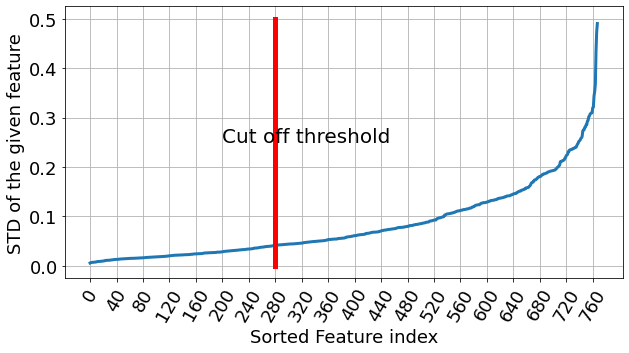

In [118]:
plt.figure(figsize=(10,5))
agg_feature_percent_missing.std().sort_values().plot(rot=60, linewidth=3, fontsize=18)
plt.grid()
plt.ylabel('STD of the given feature', fontsize=18)
I = np.arange(0,agg_feature_percent_missing.shape[1],40)
plt.yticks(fontsize=18)
plt.xticks(I,I, fontsize=18)
plt.xlabel('Sorted Feature index',fontsize=18 )
cutoff_threshold = 280
plt.plot([cutoff_threshold,cutoff_threshold],[0,.5],color='red', linewidth=5)
plt.text(200,0.25,'Cut off threshold', fontsize=20)


In [119]:
STD_cutoff_threshold = agg_feature_percent_missing.std().sort_values().iloc[280]

agg_feature_good_variance = agg_feature_percent_missing.iloc[:,agg_feature_percent_missing.std().values>STD_cutoff_threshold]
agg_feature_good_variance.shape, STD_cutoff_threshold

((1580, 487), 0.042)

##### Pairwise Correlation

In [127]:
Matrix = agg_feature_good_variance_imputed.corr()

In [131]:

pairwise_corr_tolerance = 

Matrix>

,appUsage_appPackage#80MIN#20MIN#ETP|mean,appUsage_appPackage#80MIN#20MIN#ETP|std,appUsage_appPackage#80MIN#20MIN#ASC|mean,appUsage_appPackage#80MIN#20MIN#ASC|std,appUsage_appCategory#80MIN#20MIN#ETP|mean,appUsage_appCategory#80MIN#20MIN#ETP|std,appUsage_appCategory#80MIN#20MIN#ASC|mean,appUsage_appCategory#80MIN#20MIN#ASC|std,appUsage_appCategory#80MIN#20MIN#SUP:Social/Communication|mean,appUsage_appCategory#80MIN#20MIN#SUP:Social/Communication|std,...,battery_plugState#80MIN#20MIN#SUP:AC|std,battery_status#80MIN#20MIN#SUP:CHARGING|mean,battery_status#80MIN#20MIN#SUP:CHARGING|std,headsetEvent#80MIN#20MIN#SUP:HEADSET_MIC_UNPLUGGED|mean,headsetEvent#80MIN#20MIN#SUP:HEADSET_MIC_UNPLUGGED|std,activity_event#80MIN#20MIN#SUP:ON_BICYCLE|std,connection_type#80MIN#20MIN#SUP:MOBILE|mean,connection_type#80MIN#20MIN#SUP:MOBILE|std,battery_plugState#80MIN#20MIN#SUP:WIRELESS|mean,battery_plugState#80MIN#20MIN#SUP:WIRELESS|std
appUsage_appPackage#80MIN#20MIN#ETP|mean,1.00e+00,0.39,0.82,0.48,9.66e-01,0.28,0.77,0.46,0.27,3.96e-01,...,1.92e-01,0.12,0.17,9.64e-02,1.09e-01,9.55e-02,-1.20e-03,0.05,-0.05,3.07e-03
appUsage_appPackage#80MIN#20MIN#ETP|std,3.89e-01,1.00,0.28,0.61,3.57e-01,0.90,0.27,0.53,-0.03,3.22e-01,...,1.81e-01,0.12,0.13,6.28e-02,3.69e-03,5.60e-02,1.58e-02,0.05,0.03,4.52e-02
appUsage_appPackage#80MIN#20MIN#ASC|mean,8.17e-01,0.28,1.00,0.66,7.85e-01,0.16,0.95,0.62,0.17,2.36e-01,...,1.46e-01,0.04,0.11,1.02e-01,9.41e-02,1.19e-01,3.71e-02,0.07,-0.07,-3.22e-02
appUsage_appPackage#80MIN#20MIN#ASC|std,4.79e-01,0.61,0.66,1.00,4.50e-01,0.48,0.63,0.90,0.01,2.11e-01,...,1.38e-01,0.05,0.10,4.04e-02,3.87e-02,1.16e-01,4.33e-02,0.08,-0.01,1.02e-02
appUsage_appCategory#80MIN#20MIN#ETP|mean,9.66e-01,0.36,0.79,0.45,1.00e+00,0.29,0.78,0.46,0.21,3.62e-01,...,1.78e-01,0.10,0.16,8.56e-02,1.12e-01,9.03e-02,9.78e-04,0.05,-0.05,1.24e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
activity_event#80MIN#20MIN#SUP:ON_BICYCLE|std,9.55e-02,0.06,0.12,0.12,9.03e-02,0.04,0.13,0.10,-0.02,2.18e-02,...,8.49e-03,-0.01,0.02,-5.59e-02,4.71e-02,1.00e+00,-3.27e-03,0.04,0.03,7.43e-02
connection_type#80MIN#20MIN#SUP:MOBILE|mean,-1.20e-03,0.02,0.04,0.04,9.78e-04,0.01,0.05,0.04,-0.04,-8.64e-03,...,-2.57e-02,-0.04,-0.03,8.45e-04,-1.91e-02,-3.27e-03,1.00e+00,0.38,-0.04,-3.81e-02
connection_type#80MIN#20MIN#SUP:MOBILE|std,4.53e-02,0.05,0.07,0.08,4.67e-02,0.04,0.08,0.07,-0.01,4.29e-03,...,2.29e-03,-0.03,-0.02,1.31e-02,-1.26e-02,3.53e-02,3.76e-01,1.00,-0.03,-3.28e-02
battery_plugState#80MIN#20MIN#SUP:WIRELESS|mean,-4.76e-02,0.03,-0.07,-0.01,-4.73e-02,0.03,-0.05,0.01,-0.04,-4.92e-03,...,-7.30e-02,0.21,0.12,9.71e-02,3.93e-03,3.03e-02,-3.58e-02,-0.03,1.00,7.35e-01


<AxesSubplot:>

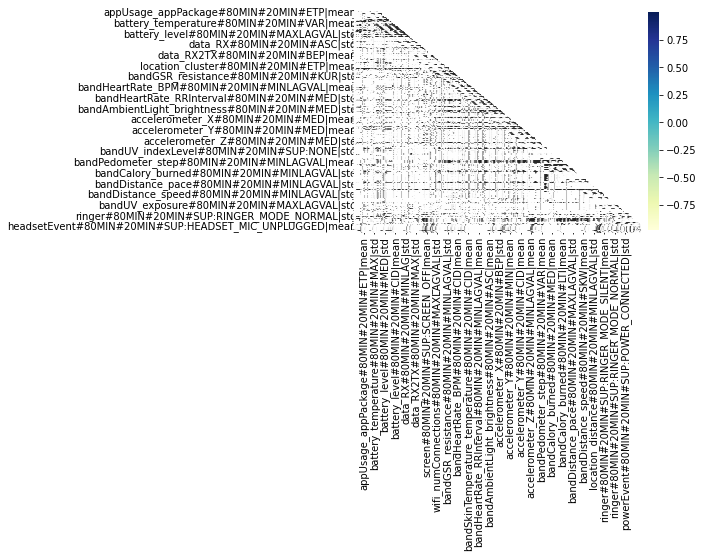

In [128]:
pd.set_option("display.precision", 2)
import seaborn as sns
sns.heatmap(
    Matrix, cmap="YlGnBu",
    fmt='.2f' 1
    ,annot=True, mask=np.triu(np.ones_like(data.corr()))
)

In [121]:
agg_feature_good_variance_imputed = impute(agg_feature_good_variance)
agg_feature_good_variance_imputed

appUsage_appPackage#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.02   
     2019-05-16 13:46:27                                      0.23   
     2019-05-16 14:28:19                                      0.12   
     2019-05-16 15:12:59                                      0.18   
     2019-05-16 16:41:48                                      0.50   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.44   
     2019-05-14 18:54:15                                      0.46   
     2019-05-14 19:33:13                                      0.48   
     2019-05-14 20:16:19                                      0.59   
     2019-05-14 21:02:23                                      0.40   

                          appUsage_appPackage#80MIN#20MIN#ETP|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.03   
     2019-05-16 13:46:27                                     0.20   
     2019-05-16 14:28:19                                     0.19   
     2019-05-16 15:12:59                                     0.28   
     2019-05-16 16:41:48                                     0.10   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.17   
     2019-05-14 18:54:15                                     0.20   
     2019-05-14 19:33:13                                     0.17   
     2019-05-14 20:16:19                                     0.11   
     2019-05-14 21:02:23                                     0.23   

                          appUsage_appPackage#80MIN#20MIN#ASC|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.01   
     2019-05-16 13:46:27                                      0.07   
     2019-05-16 14:28:19                                      0.04   
     2019-05-16 15:12:59                                      0.10   
     2019-05-16 16:41:48                                      0.15   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.14   
     2019-05-14 18:54:15                                      0.17   
     2019-05-14 19:33:13                                      0.12   
     2019-05-14 20:16:19                                      0.18   
     2019-05-14 21:02:23                                      0.15   

                          appUsage_appPackage#80MIN#20MIN#ASC|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.02   
     2019-05-16 13:46:27                                     0.06   
     2019-05-16 14:28:19                                     0.05   
     2019-05-16 15:12:59                                     0.13   
     2019-05-16 16:41:48                                     0.04   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.07   
     2019-05-14 18:54:15                                     0.10   
     2019-05-14 19:33:13                                     0.07   
     2019-05-14 20:16:19                                     0.05   
     2019-05-14 21:02:23                                     0.10   

                          appUsage_appCategory#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                        
1501 2019-05-16 12:17:02                                       0.02   
     2019-05-16 13:46:27                                       0.16   
     2019-05-16 14:28:19                                       0.13   
     2019-05-16 15:12:59                             

In [124]:
data = pd.merge(
    labels_arm[['receptivity']],
    agg_feature_good_variance_imputed
    ,left_index=True, right_index=True
)
data   

receptivity  \
pid timestamp                            
718 2019-05-08 10:00:36  non-receptive   
    2019-05-08 15:59:55      receptive   
    2019-05-08 16:42:24      receptive   
    2019-05-08 20:25:33  non-receptive   
    2019-05-09 13:40:32  non-receptive   
...                                ...   
716 2019-05-13 19:30:45      receptive   
    2019-05-14 12:54:46      receptive   
    2019-05-14 16:47:23      receptive   
    2019-05-14 19:43:12      receptive   
    2019-05-14 21:58:17      receptive   

                         appUsage_appPackage#80MIN#20MIN#ETP|mean  \
pid timestamp                                                       
718 2019-05-08 10:00:36                                      0.18   
    2019-05-08 15:59:55                                      0.06   
    2019-05-08 16:42:24                                      0.25   
    2019-05-08 20:25:33                                      0.30   
    2019-05-09 13:40:32                                      0.08   
...                                                           ...   
716 2019-05-13 19:30:45                                      0.12   
    2019-05-14 12:54:46                                      0.36   
    2019-05-14 16:47:23                                      0.26   
    2019-05-14 19:43:12                                      0.20   
    2019-05-14 21:58:17                                      0.13   

                         appUsage_appPackage#80MIN#20MIN#ETP|std  \
pid timestamp                                                      
718 2019-05-08 10:00:36                                     0.24   
    2019-05-08 15:59:55                                     0.11   
    2019-05-08 16:42:24                                     0.22   
    2019-05-08 20:25:33                                     0.22   
    2019-05-09 13:40:32                                     0.17   
...                                                          ...   
716 2019-05-13 19:30:45                                     0.19   
    2019-05-14 12:54:46                                     0.15   
    2019-05-14 16:47:23                                     0.33   
    2019-05-14 19:43:12                                     0.15   
    2019-05-14 21:58:17                                     0.15   

                         appUsage_appPackage#80MIN#20MIN#ASC|mean  \
pid timestamp                                                       
718 2019-05-08 10:00:36                                  3.28e-02   
    2019-05-08 15:59:55                                  3.28e-02   
    2019-05-08 16:42:24                                  1.21e-01   
    2019-05-08 20:25:33                                  5.33e-02   
    2019-05-09 13:40:32                                  3.48e-02   
...                                                           ...   
716 2019-05-13 19:30:45                                  2.66e-02   
    2019-05-14 12:54:46                                  7.38e-02   
    2019-05-14 16:47:23                                  6.76e-02   
    2019-05-14 19:43:12                                  7.38e-02   
    2019-05-14 21:58:17                                  8.20e-03   

                         appUsage_appPackage#80MIN#20MIN#ASC|std  \
pid timestamp                                                      
718 2019-05-08 10:00:36                                 3.28e-02   
    2019-05-08 15:59:55                                 6.56e-02   
    2019-05-08 16:42:24                                 9.73e-02   
    2019-05-08 20:25:33                                 3.82e-02   
    2019-05-09 13:40:32                                 6.97e-02   
...                                                          ...   
716 2019-05-13 19:30:45                                 3.87e-02   
    2019-05-14 12:54:46                                 6.10e-02   
    2019-05-14 16:47:23                                 7.09e-02   
    2019-05-14 19:43:12                            

In [125]:
data.isnull().sum(axis=0)

receptivity                                        0
appUsage_appPackage#80MIN#20MIN#ETP|mean           0
appUsage_appPackage#80MIN#20MIN#ETP|std            0
appUsage_appPackage#80MIN#20MIN#ASC|mean           0
appUsage_appPackage#80MIN#20MIN#ASC|std            0
                                                  ..
activity_event#80MIN#20MIN#SUP:ON_BICYCLE|std      0
connection_type#80MIN#20MIN#SUP:MOBILE|mean        0
connection_type#80MIN#20MIN#SUP:MOBILE|std         0
battery_plugState#80MIN#20MIN#SUP:WIRELESS|mean    0
battery_plugState#80MIN#20MIN#SUP:WIRELESS|std     0
Length: 488, dtype: int64

In [ ]:
sub_features_d={}
windows = {
    '30MIN': 30 * 60,
    '1HR'  : 1*60 * 60,
    '3HR'  : 3*60 * 60,
    '6HR'  : 6*60 * 60,
    '9HR'  : 9*60 * 60,
    '12HR' : 12*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
    for window_name, window_size  in windows.items():
        sub_features_d[window_name] = dataset.parallellize_extract_sub(
            labels=labels_arm, 
            w_name=window_name,
            w_size = window_size,
            use_ray=True
        )


In [ ]:
aggregated_features_d = {}
for k,v in sub_features_d.items():
    
    imputed_sub_feature = impute_sub_features(v)
    print(k)
    print(imputed_sub_feature.isnull().sum(axis=0).sum())
    
    agg_feature = imputed_sub_feature.groupby(['pid','timestamp']).agg(['mean','std'])
    agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
    agg_feature = drop_zero_varience_features(agg_feature)
    
    aggregated_features_d[k] = agg_feature
    agg_feature.to_csv(f'features/{k}_aggregated_features.csv')


In [ ]:
topq = 40
MEASUREMENTS = []

for k,X in aggregated_features_d.items():    
    feature_names = X.columns.tolist()
    data = pd.merge(labels_arm,X, left_index=True, right_index=True)

    X = data[['disturbance']+feature_names]
    corr = X.corr()[['disturbance']].abs().sort_values('disturbance',ascending=False)
    correlated_features = corr.head(40).index.values[1:].tolist()

    measure = run_classification(data.reset_index(), correlated_features=correlated_features)
    measure.insert(0,'window',k)
    MEASUREMENTS.append(measure)

MEASUREMENTS_loso = MEASUREMENTS[MEASUREMENTS.CV_TYPE=='LOSO']
MEASUREMENTS_CV = MEASUREMENTS[MEASUREMENTS.CV_TYPE=='5-fold CV']


In [ ]:
res = MEASUREMENTS_loso.groupby(['window','CV_TYPE'], as_index=False).mean()
res = res.assign(
    window_size = lambda x: x.window
)
res.window_size = res.window_size.replace({'12HR':12*60,'1HR':1*60,'30MIN':30,'3HR':3*60,'6HR':6*60,'9HR':9*60})
res = res.sort_values('window_size')
res.groupby(['window','CV_TYPE']).mean().sort_values('window_size')

In [ ]:
res = MEASUREMENTS_CV.groupby(['window','CV_TYPE'], as_index=False).mean()
res = res.assign(
    window_size = lambda x: x.window
)
res.window_size = res.window_size.replace({'12HR':12*60,'1HR':1*60,'30MIN':30,'3HR':3*60,'6HR':6*60,'9HR':9*60})
res = res.sort_values('window_size')
res.groupby(['window','CV_TYPE']).mean().sort_values('window_size')

### full window features

In [ ]:
full_features_d={}
windows = {
    # '30MIN': 30 * 60,
    # '1HR': 1*60 * 60,
     '3HR': 3*60 * 60,
    # '6HR': 6*60 * 60,
    # '9HR': 9*60 * 60,
    # '12HR': 12*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
    for window_name, window_size  in windows.items():
        full_features_d[window_name] = dataset.parallellize_extract(
            labels=labels_arm, 
            w_name=window_name,
            w_size = window_size,
            use_ray=True
        )

        
    

In [ ]:
full_features_d['3HR'].shape

In [ ]:
labels_arm.reset_index().set_index(labels_arm.index.names)
labels_arm.head()

In [ ]:
for k,v in full_features_d.items():
    
    imputed_feature = impute_features(v)
    assert imputed_feature.isnull().sum(axis=0).sum()==0, f'after immputation there should not be any null cells, but there are {imputed_feature.isnull().sum(axis=0).sum()}'
    
    imputed_feature = drop_zero_varience_features(imputed_feature)
    
    full_features_d[k] = imputed_feature
    imputed_feature.to_csv(f'features/{k}_full_features.csv')


In [ ]:
def get_window_name(fn):
    return fn[:fn.find('_')]
get_window_name('12HR_full_features.csv')

In [ ]:
topq = 40
MEASUREMENTS = []

#for k,X in full_features_d.items():
for fn in glob(join('features/*_full_features.csv')):
    window = get_window_name(ntpath.basename(fn))
    print(window)
    X = pd.read_csv(fn, parse_dates=['timestamp'], dtype={'pid':str})
    X.set_index(['pid','timestamp'],inplace=True)

    X = X.drop_duplicates()
    feature_names = X.columns.tolist()
    data = pd.merge(labels_arm,X, left_index=True, right_index=True)

    X = data[['disturbance']+feature_names]
    corr = X.corr()[['disturbance']].abs().sort_values('disturbance',ascending=False)
    correlated_features = corr.head(40).index.values[1:].tolist()

    measure = run_classification(data.reset_index(), correlated_features=correlated_features)
    measure.insert(0,'window',window)
    MEASUREMENTS.append(measure)
MEASUREMENTS = pd.concat(MEASUREMENTS)
MEASUREMENTS_loso = MEASUREMENTS[MEASUREMENTS.CV_TYPE=='LOSO']
MEASUREMENTS_CV = MEASUREMENTS[MEASUREMENTS.CV_TYPE=='5-fold-CV']


In [ ]:
res = MEASUREMENTS_loso.groupby(['window','CV_TYPE'], as_index=False).mean()
res = res.assign(
    window_size = lambda x: x.window
)
res.window_size = res.window_size.replace({'12HR':12*60,'1HR':1*60,'30MIN':30,'3HR':3*60,'6HR':6*60,'9HR':9*60})
res.groupby(['window','CV_TYPE']).mean().sort_values('window_size')

In [ ]:
res = MEASUREMENTS_CV.groupby(['window','CV_TYPE'], as_index=False).mean()
res = res.assign(
    window_size = lambda x: x.window
)
res.window_size = res.window_size.replace({'12HR':12*60,'1HR':1*60,'30MIN':30,'3HR':3*60,'6HR':6*60,'9HR':9*60})

res.groupby(['window','CV_TYPE']).mean().sort_values('window_size')

In [ ]:
%%R -i MEASUREMENTS -w 40 -h 16 -u cm

data <- MEASUREMENTS %>% pivot_longer(
    cols = starts_with('ACC'), 
    names_to = 'metric',
    values_to = 'value'
)
data$WIN <- factor(data$window, levels=c('30MIN','1HR','3HR','6HR','9HR','12HR'))

p <- ggplot(data, aes(x=metric, y=value, colour=WIN)) +
        geom_boxplot() +
        THEME_DEFAULT + 
        labs(
            x='Metrics',
            y='Percentage'
        ) + 
        facet_grid(
            rows=vars(CV_TYPE)
        ) + 
        ylim(.0, 1) +
        theme(
            legend.position='bottom',
            legend.title=element_blank(),
            legend.background=element_blank(),
            legend.text=element_text(colour="grey20", size=13, angle=0, hjust=.0, face='bold'),
            axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=2)
        )+
        guides(fill=guide_legend(nrow=1,byrow=FALSE))
print(p)  

- 3 hr window for both aggregated and full features
    - because results are relatively better
    - intuitively 3hr with 30min sub windows are more meaningfull for ARM

### number of features Experiment
#### correlation based

In [ ]:
df_agg = pd.read_csv(f'features/3HR_aggregated_features.csv', parse_dates=['timestamp'], dtype={'pid':str})
df_agg.set_index(['pid','timestamp'],inplace=True)
df_agg = df_agg.drop_duplicates()
df_agg.shape

In [ ]:
df_full = pd.read_csv(f'features/3HR_full_features.csv', parse_dates=['timestamp'], dtype={'pid':str})
df_full.set_index(['pid','timestamp'],inplace=True)

df_full = df_full.drop_duplicates()
df_full.shape

In [ ]:

MEASUREMENTS = []

for topq in np.arange(10,300,50):    
    print(f'topq:{topq}')
    X = X.assign(
        disturbance = labels_arm['disturbance']
    )
    corr = X.corr()[['disturbance']].abs().sort_values('disturbance',ascending=False)
    correlated_features = corr.head(topq).index.values[1:].tolist()    
    data = pd.merge(labels_arm[['is_opportune_moment']],df_agg[correlated_features], left_index=True, right_index=True)
    
    measure = run_classification(data.reset_index())
    measure.insert(0,'feature_type','agg')
    measure.insert(0,'topq',topq)    
    MEASUREMENTS.append(measure)
    
    # full
    feature_names = df_full.columns.tolist()
    data = pd.merge(labels_arm,df_full, left_index=True, right_index=True)
    X = data[['disturbance']+feature_names]
    corr = X.corr()[['disturbance']].abs().sort_values('disturbance',ascending=False)
    correlated_features = corr.head(topq).index.values[1:].tolist()
    
    measure = run_classification(data.reset_index(), correlated_features=correlated_features)
    measure.insert(0,'feature_type','full')
    measure.insert(0,'topq',topq)    
    MEASUREMENTS.append(measure)
    
    
    
MEASUREMENTS = pd.concat(MEASUREMENTS)


In [ ]:
data.reset_index()

In [ ]:
MEASUREMENTS[MEASUREMENTS.CV_TYPE=='LOSO'].groupby(['feature_type','topq','CV_TYPE']).mean()

In [ ]:
loso_meas=MEASUREMENTS[MEASUREMENTS.CV_TYPE=='LOSO'].groupby(['feature_type','topq','CV_TYPE'], as_index=False).mean()
loso_meas

In [ ]:
MEASUREMENTS[(MEASUREMENTS.CV_TYPE=='LOSO') & (MEASUREMENTS.feature_type=='agg')].groupby(['feature_type','topq','CV_TYPE'], as_index=False).mean().head(10)

In [ ]:
MEASUREMENTS[(MEASUREMENTS.CV_TYPE=='LOSO') & (MEASUREMENTS.feature_type=='full')].groupby(['feature_type','topq','CV_TYPE'], as_index=False).mean().head(10)

In [ ]:
%%R -i loso_meas -w 40 -h 16 -u cm
require(plyr)
loso_meas$ACC_BAL<- loso_meas$ACC_BAL*100
loso_meas$feature_type <- mapvalues(loso_meas$feature_type, 
          from=c("agg","full"), 
          to=c("Aggregated Features (similar to CFF-depression)","Full Features (Same as Woohyeok's) "))
ggplot(data = loso_meas, mapping = aes(x = topq, y = ACC_BAL, color = feature_type)) +
  geom_line() +
    labs(
            x='Number of selected features',
            y='Balanced Accuracy (%)'
        ) +
    theme(
            legend.position='bottom',
            legend.title=element_blank(),
            legend.background=element_blank(),
            legend.text=element_text(colour="grey20", size=13, angle=0, hjust=.0, face='bold'),
            axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=2)
        )+
        guides(fill=guide_legend(nrow=1,byrow=FALSE))

#### Regression based

In [ ]:

MEASUREMENTS = []

for topq in np.arange(1,70,1):    
    print(f'topq:{topq}')
    # agg
    feature_names = df_agg.columns.tolist()
    data = pd.merge(labels_arm,df_agg, left_index=True, right_index=True)
    X = data[['disturbance']+feature_names]
    measure = run_classification(data.reset_index(), topq)
    measure.insert(0,'feature_type','agg')
    measure.insert(0,'topq',topq)    
    MEASUREMENTS.append(measure)
    
    # full
    feature_names = df_full.columns.tolist()
    data = pd.merge(labels_arm,df_full, left_index=True, right_index=True)
    X = data[['disturbance']+feature_names]
    
    measure = run_classification(data.reset_index(), topq)
    measure.insert(0,'feature_type','full')
    measure.insert(0,'topq',topq)    
    MEASUREMENTS.append(measure)
    
MEASUREMENTS = pd.concat(MEASUREMENTS)


### Mine Association Rules
- on RuleGenerateSet
- select sub featurs using RuleGenerate Set
- 

#### Feature selection
- extract sub features for the selected window size
- compute aggregated features
- exclude multicolliniear features
    - select aggregated features with correlation threshold of .06 

In [242]:
sub_features_d={}
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        sub_features_d[window_name] = dataset.parallellize_extract_sub(
            labels=labels_arm, 
            w_name=window_name,
            w_size = window_size,
            use_ray=True
        )


2022-01-06 10:39:43,395	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
 45%|████▍     | 17/38 [04:47<00:53,  2.53s/it](pid=470) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
(pid=470)   **kwargs)
(pid=470) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
(pid=470)   ret = ret.dtype.type(ret / rcount)
(pid=470) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
(pid=470)   slope = ssxym / ssxm
(pid=470) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
(pid=470)   t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
(pid=470) /data/juma/anaconda3/envs/re

In [258]:
df_sub = sub_features_d['6HR']
df_sub.shape

(19260, 378)

- feature preprocessing
    - imputation
        - fill in NAN support features with 0
        - impute on participant level
    - drop zero variance features

In [244]:

df_sub = impute_by_filling_support_features(df_sub)
df_sub.iloc[:,df_sub.columns.str.contains('SUP')].std().sum()

  0%|          | 0/38 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 38/38 [00:01<00:00, 34.37it/s]


5.833762741296685

In [245]:
df_sub = impute_with_mean_of_participant(df_sub)
df_sub.shape

100%|██████████| 38/38 [00:02<00:00, 12.71it/s]


(19260, 378)

In [246]:
agg_feature = df_sub.groupby(['pid','timestamp']).agg(['mean','std'])
agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
agg_feature = drop_zero_varience_features(agg_feature)

0 from total of 756 is dropped


- save & load data

In [247]:
agg_feature.to_csv(f'features/agg-window_6HR-numSub_12_FS.csv')


In [248]:
agg_feature = pd.read_csv(f'features/agg-window_6HR-numSub_12_FS.csv')
agg_feature.set_index(['pid','timestamp'], inplace=True)

agg_feature.shape

(1605, 756)

#### correlation based feature slection
- exclude multicolliniearity
- then select based on CORR_threshold

- exc collinier features

In [249]:


collinarity_corr_threshold = .7
X = deepcopy(agg_feature)
X.insert(0,'disturbance', labels_arm['disturbance'].values)
multi_colliniearity_df = X.corr().sort_values('disturbance',key=abs, ascending=False).iloc[1:,1:]
excluded_features = get_colliniear_features(multi_colliniearity_df,collinarity_corr_threshold)


kept_features = list(set(multi_colliniearity_df.columns)-set(excluded_features) )
print(f'{len(kept_features)} aggregated features are kept after excluding colliniarity among the total of {multi_colliniearity_df.shape[0]}:')

265 aggregated features are kept after excluding colliniarity among the total of 756:


In [251]:
X[['disturbance']+kept_features].corr()['disturbance'].sort_values(key=abs, ascending=False).iloc[1:]

battery_temperature#6HR#30MIN#MAX|mean               -0.136579
battery_temperature#6HR#30MIN#VAR|mean               -0.134907
data_RX2TX#6HR#30MIN#ASC|std                         -0.129015
battery_level#6HR#30MIN#MIN|std                      -0.124879
battery_temperature#6HR#30MIN#ASC|mean               -0.120702
                                                        ...   
connection_type#6HR#30MIN#SUP:WIFI|std                0.001255
bandSkinTemperature_temperature#6HR#30MIN#LTS|mean    0.001051
bandUV_indexLevel#6HR#30MIN#SUP:NONE|std             -0.000641
bandCalory_burned#6HR#30MIN#LTS|mean                 -0.000365
data_RX2TX#6HR#30MIN#LTS|mean                        -0.000101
Name: disturbance, Length: 265, dtype: float64

- plot the correlation of selected features wiht outcome variable

In [252]:
CORRELATION_THRESHOLD=.08
I = np.linspace(0,1,100)
ds = X[['disturbance']+kept_features].corr()['disturbance'].iloc[1:].sort_values(key=abs,ascending=False)

# features w/ corr. larger than 0.08 are: 30/265


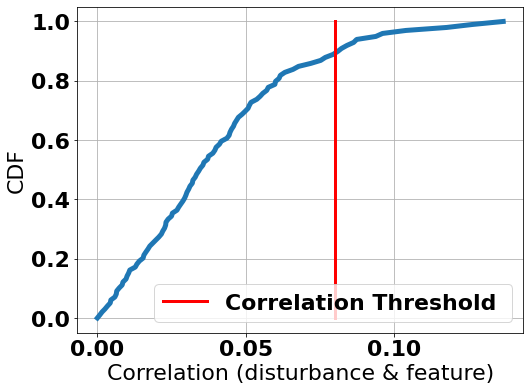

In [253]:
print(f'# features w/ corr. larger than {CORRELATION_THRESHOLD} are: {ds[ds.abs()>CORRELATION_THRESHOLD].shape[0]}/{len(kept_features)}')
plt.plot(ds.abs().quantile(I),I, linewidth=5)
plt.ylabel('CDF')
plt.xlabel('Correlation (disturbance & feature)')
plt.grid(True)
plt.plot([CORRELATION_THRESHOLD, CORRELATION_THRESHOLD],[0,1], linewidth=3, color='red', label='Correlation Threshold ' )
plt.legend()

In [254]:
selected_features = ds[ds.abs()>CORRELATION_THRESHOLD].index.tolist()
len(selected_features)

30

- map selected aggregated features to subfeatures

In [255]:
selected_features_mapped = list(set(map(lambda x: x[:x.find('|')], selected_features)))
print('sub features selected (mapped from agg. features):',len(selected_features_mapped))

sub features selected (mapped from agg. features): 30


In [256]:
selected_features_mapped

['activity_event#6HR#30MIN#ETP',
 'battery_temperature#6HR#30MIN#VAR',
 'bandUV_indexLevel#6HR#30MIN#ETP',
 'bandUV_exposure#6HR#30MIN#MAX',
 'data_RX2TX#6HR#30MIN#ASC',
 'battery_plugState#6HR#30MIN#SUP:WIRELESS',
 'appUsage_appCategory#6HR#30MIN#SUP:Productivity/Business',
 'location_distance#6HR#30MIN#CID',
 'data_RX#6HR#30MIN#CID',
 'battery_plugState#6HR#30MIN#SUP:AC',
 'location_cluster#6HR#30MIN#ETP',
 'bandDistance_speed#6HR#30MIN#ASC',
 'bandUV_indexLevel#6HR#30MIN#ASC',
 'battery_status#6HR#30MIN#ETP',
 'appUsage_appCategory#6HR#30MIN#SUP:Social/Communication',
 'bandDistance_speed#6HR#30MIN#CID',
 'data_RX2TX#6HR#30MIN#CID',
 'data_TX#6HR#30MIN#CID',
 'bandHeartRate_RRInterval#6HR#30MIN#MAXLAG',
 'battery_temperature#6HR#30MIN#LTI',
 'battery_plugState#6HR#30MIN#SUP:USB',
 'activity_event#6HR#30MIN#SUP:STILL',
 'appUsage_appCategory#6HR#30MIN#ETP',
 'bandUV_exposure#6HR#30MIN#BEP',
 'battery_temperature#6HR#30MIN#ASC',
 'battery_level#6HR#30MIN#VAR',
 'bandDistance_pace#6HR#

#### extract sliding sub features
- selected window 3hr

In [257]:
import dataset
sliding_features_d={}
windows = {
    '6HR': 6*60 * 60 # hr=>min=>sec
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
    for window_name, window_size  in windows.items():
        sliding_features_d[window_name] = dataset.parallellize_extract_sliding(
            labels=labels_arm, 
            w_name=window_name,
            w_size = window_size,
            selected_features=selected_features_mapped,
            use_ray=True,            
        )

        
    

2022-01-06 10:47:23,358	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
100%|██████████| 38/38 [05:22<00:00,  8.48s/it]


In [268]:
sliding_subfeatures = sliding_features_d['6HR']
sliding_subfeatures.shape

(6384, 30)

In [270]:
sliding_subfeatures.isnull().sum(axis=0).sort_values(ascending=False)

battery_plugState#6HR#30MIN#SUP:WIRELESS                    6311
battery_plugState#6HR#30MIN#SUP:USB                         6222
appUsage_appCategory#6HR#30MIN#SUP:Productivity/Business    5905
battery_plugState#6HR#30MIN#SUP:AC                          5027
appUsage_appCategory#6HR#30MIN#SUP:Social/Communication     1931
activity_event#6HR#30MIN#SUP:STILL                           575
bandUV_exposure#6HR#30MIN#BEP                                492
bandUV_exposure#6HR#30MIN#MAX                                492
bandUV_indexLevel#6HR#30MIN#ASC                              491
bandUV_indexLevel#6HR#30MIN#ETP                              491
bandGSR_resistance#6HR#30MIN#MAXLAGVAL                       484
bandDistance_speed#6HR#30MIN#CID                             484
bandDistance_speed#6HR#30MIN#ASC                             484
bandDistance_pace#6HR#30MIN#AVG                              484
bandHeartRate_RRInterval#6HR#30MIN#MAXLAG                    484
activity_event#6HR#30MIN#

In [271]:
sliding_subfeatures = impute_by_filling_support_features(sliding_subfeatures)
sliding_subfeatures.isnull().sum(axis=0).sort_values(ascending=False)

  0%|          | 0/38 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
100%|██████████| 38/38 [00:00<00:00, 161.54it/s]


bandUV_exposure#6HR#30MIN#BEP                               492
bandUV_exposure#6HR#30MIN#MAX                               492
bandUV_indexLevel#6HR#30MIN#ASC                             491
bandUV_indexLevel#6HR#30MIN#ETP                             491
bandDistance_speed#6HR#30MIN#CID                            484
bandDistance_speed#6HR#30MIN#ASC                            484
bandDistance_pace#6HR#30MIN#AVG                             484
bandHeartRate_RRInterval#6HR#30MIN#MAXLAG                   484
bandGSR_resistance#6HR#30MIN#MAXLAGVAL                      484
activity_event#6HR#30MIN#ETP                                349
location_distance#6HR#30MIN#CID                             326
location_cluster#6HR#30MIN#ETP                              321
data_RX2TX#6HR#30MIN#CID                                    319
data_RX#6HR#30MIN#CID                                       319
data_TX#6HR#30MIN#CID                                       319
data_RX2TX#6HR#30MIN#ASC                

#### Recode

In [278]:

    
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count2 = 0
    count1 = 0
    count3 = 0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    print("The numbers of 1-3 labels of PID{} are: {}, {}, {}".format(pid, count1, count2, count3))
    df.insert(0,'pid',pid)
    df = df.reset_index().set_index(['pid']+data.index.names)
    return df


df_recoded = [] 
for pid in tqdm(sliding_subfeatures.index.get_level_values('pid').unique()):    
    res = discretize_df(sliding_subfeatures.loc[pid],sliding_subfeatures.columns.tolist(), pid)
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()

  8%|▊         | 3/38 [00:00<00:03, 10.53it/s]

The numbers of 1-3 labels of PID3002 are: 10, 6, 14
The numbers of 1-3 labels of PID1509 are: 13, 2, 15
The numbers of 1-3 labels of PID1503 are: 11, 5, 14


 13%|█▎        | 5/38 [00:00<00:03,  9.66it/s]

The numbers of 1-3 labels of PID712 are: 16, 1, 13
The numbers of 1-3 labels of PID1506 are: 15, 1, 14


 18%|█▊        | 7/38 [00:00<00:02, 10.36it/s]

The numbers of 1-3 labels of PID3012 are: 10, 6, 14
The numbers of 1-3 labels of PID3022 are: 13, 3, 14
The numbers of 1-3 labels of PID3018 are: 10, 6, 14


 29%|██▉       | 11/38 [00:01<00:02, 10.97it/s]

The numbers of 1-3 labels of PID701 are: 13, 3, 14
The numbers of 1-3 labels of PID3007 are: 13, 3, 14
The numbers of 1-3 labels of PID3014 are: 16, 1, 13


 34%|███▍      | 13/38 [00:01<00:02, 11.38it/s]

The numbers of 1-3 labels of PID1508 are: 14, 2, 14
The numbers of 1-3 labels of PID1505 are: 14, 2, 14
The numbers of 1-3 labels of PID721 are: 11, 5, 14


 45%|████▍     | 17/38 [00:01<00:01, 13.02it/s]

The numbers of 1-3 labels of PID1519 are: 17, 0, 13
The numbers of 1-3 labels of PID1521 are: 11, 5, 14
The numbers of 1-3 labels of PID1526 are: 13, 4, 13
The numbers of 1-3 labels of PID3015 are: 10, 6, 14


 55%|█████▌    | 21/38 [00:01<00:01, 14.29it/s]

The numbers of 1-3 labels of PID725 are: 14, 3, 13
The numbers of 1-3 labels of PID1507 are: 11, 5, 14
The numbers of 1-3 labels of PID1514 are: 9, 7, 14
The numbers of 1-3 labels of PID1502 are: 10, 6, 14


 66%|██████▌   | 25/38 [00:01<00:00, 14.92it/s]

The numbers of 1-3 labels of PID726 are: 13, 4, 13
The numbers of 1-3 labels of PID1515 are: 15, 1, 14
The numbers of 1-3 labels of PID728 are: 10, 5, 15
The numbers of 1-3 labels of PID3017 are: 15, 2, 13


 76%|███████▋  | 29/38 [00:02<00:00, 15.26it/s]

The numbers of 1-3 labels of PID724 are: 10, 2, 18
The numbers of 1-3 labels of PID1511 are: 11, 5, 14
The numbers of 1-3 labels of PID1518 are: 13, 2, 15
The numbers of 1-3 labels of PID3016 are: 16, 1, 13


 87%|████████▋ | 33/38 [00:02<00:00, 13.13it/s]

The numbers of 1-3 labels of PID1501 are: 10, 3, 17
The numbers of 1-3 labels of PID1520 are: 15, 2, 13
The numbers of 1-3 labels of PID1504 are: 13, 5, 12


 92%|█████████▏| 35/38 [00:02<00:00, 12.69it/s]

The numbers of 1-3 labels of PID3009 are: 16, 5, 9
The numbers of 1-3 labels of PID719 are: 13, 3, 14
The numbers of 1-3 labels of PID718 are: 14, 3, 13


100%|██████████| 38/38 [00:03<00:00, 12.65it/s]

The numbers of 1-3 labels of PID3003 are: 16, 1, 13
The numbers of 1-3 labels of PID3028 are: 13, 3, 14


appUsage_appCategory#6HR#30MIN#ETP  \
pid  sliding_timestamp                                        
3002 2019-04-30 10:30:00                                  l   
     2019-04-30 11:00:00                                  l   
     2019-04-30 11:30:00                                  h   
     2019-04-30 12:00:00                                  h   
     2019-04-30 12:30:00                                  h   

                         battery_temperature#6HR#30MIN#MAX  \
pid  sliding_timestamp                                       
3002 2019-04-30 10:30:00                                 m   
     2019-04-30 11:00:00                                 m   
     2019-04-30 11:30:00                                 h   
     2019-04-30 12:00:00                                 m   
     2019-04-30 12:30:00                                 l   

                         battery_temperature#6HR#30MIN#VAR  \
pid  sliding_timestamp                                       
3002 2019-04-30 10:30:00                                 l   
     2019-04-30 11:00:00                                 l   
     2019-04-30 11:30:00                                 m   
     2019-04-30 12:00:00                                 m   
     2019-04-30 12:30:00                                 m   

                         battery_temperature#6HR#30MIN#ASC  \
pid  sliding_timestamp                                       
3002 2019-04-30 10:30:00                                 l   
     2019-04-30 11:00:00                                 l   
     2019-04-30 11:30:00                                 m   
     2019-04-30 12:00:00                                 m   
     2019-04-30 12:30:00                                 m   

                         battery_temperature#6HR#30MIN#LTI  \
pid  sliding_timestamp                                       
3002 2019-04-30 10:30:00                                 m   
     2019-04-30 11:00:00                                 m   
     2019-04-30 11:30:00                                 h   
     2019-04-30 12:00:00                                 m   
     2019-04-30 12:30:00                                 m   

                         battery_level#6HR#30MIN#MIN  \
pid  sliding_timestamp                                 
3002 2019-04-30 10:30:00                           h   
     2019-04-30 11:00:00                           h   
     2019-04-30 11:30:00                           h   
     2019-04-30 12:00:00                           h   
     2019-04-30 12:30:00                           h   

                         battery_level#6HR#30MIN#VAR  \
pid  sliding_timestamp                                 
3002 2019-04-30 10:30:00                           l   
     2019-04-30 11:00:00                           l   
     2019-04-30 11:30:00                           m   
     2019-04-30 12:00:00                           m   
     2019-04-30 12:30:00                           m   

                         battery_plugState#6HR#30MIN#SUP:AC  \
pid  sliding_timestamp                                        
3002 2019-04-30 10:30:00                                  m   
     2019-04-30 11:00:00                                  m   
     2019-04-30 11:30:00                                  m   
     2019-04-30 12:00:00                                  m   
     2019-04-30 12:30:00                                  m   

                         battery_status#6HR#30MIN#ETP  \
pid  sliding_timestamp                                  
3002 2019-04-30 10:30:00                            m   
     2019-04-30 11:00:00                            m   
     2019-04-30 11:30:00                            m   
     2019-04-30 12:00:00                            m   
     2019-04-30 12:30:00                            m   

                         location_cluster#6HR#30MIN#ETP  ...  \
pid  sliding_timestamp                                   ...   
3002 2019-04-30 10:30:00                              l  ...   
     2019-04-30 11:00:0

#### mine Rules

In [279]:
%load_ext rpy2.ipython

In [280]:
%%R

library(tibble)
library(dplyr)
library(forcats)
library(tidyr)
library(purrr)
library(psych)
library(stringr)
library(ggplot2)

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='Arial',
) +
theme(
    axis.title.x=element_text(colour="grey20",size=13,angle=0,hjust=.5,vjust=.5, face="bold"),
    axis.title.y=element_text(colour="grey20",size=13,angle=90,hjust=.5,vjust=1, face="bold"),
    axis.text.x=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    axis.text.y=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    strip.text.x=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.25, face="bold"),
    strip.text.y=element_text(colour="grey20",size=13,angle=270,hjust=.5,vjust=.5, face="bold"),
    legend.title=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.5,face="bold"),
    legend.position='top'
)


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

R[write to console]: 
Attaching package: ‘ggplot2’


R[write to console]: The following objects are masked from ‘package:psych’:

    %+%, alpha




In [281]:
%%R -i df_recoded
library('arules')
library('arulesViz')
library('stringr')
library('tidyverse')
library('glue')

data <- as.data.frame((df_recoded))

for (mlen in 2:10){
    print('------------')
    print(glue("mlen:{mlen}"))
    rules <- apriori(data, parameter=list( supp=.3, conf=0.3,  minlen=2,maxlen=mlen))
        
    topRules = head(rules, n = 1000, by = "lift")
    d <- as(topRules, "data.frame")
    write.csv(d, file.path('rules',glue("rules1000-mlen_{mlen}.csv")))
}


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘arules’


R[write to console]: The following object is masked from ‘package:dplyr’:

    recode


R[write to console]: The following objects are masked from ‘package:base’:

    abbreviate, write


R[write to console]: ── Attaching packages ─── tidyverse 1.3.0 ──

R[write to console]: ✔ readr 1.4.0     

R[write to console]: ── Conflicts ────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ Matrix::expand() masks tidyr::expand()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ Matrix::pack()   masks tidyr::pack()
✖ arules::recode() masks dplyr::recode()
✖ Matrix::unpack() masks tidyr::unpack()

R[write to console]: 
Attaching package: ‘glue’


R[wri

[1] "------------"
mlen:2
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.3      2
 maxlen target  ext
      2  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 1915 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[96 item(s), 6384 transaction(s)] done [0.02s].
sorting and recoding items ... [56 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 done [0.01s].
writing ... [968 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
[1] "------------"
mlen:3
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.3      2
 maxlen target  ext
      3  rules TRUE

Algorithmic co

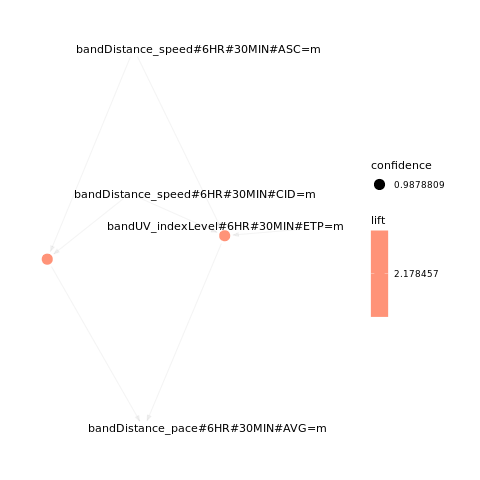

In [282]:
%%R
plot(head(topRules,n=2), method = "graph", 
     measure = "confidence", shading = "lift")

In [289]:
%%R
inspect(head(topRules,n=10))

     lhs                                                              rhs                                   support confidence coverage     lift count
[1]  {bandDistance_speed#6HR#30MIN#ASC=m,                                                                                                             
      bandDistance_speed#6HR#30MIN#CID=m}                          => {bandDistance_pace#6HR#30MIN#AVG=m} 0.4468985  0.9878809 0.452381 2.178457  2853
[2]  {bandUV_indexLevel#6HR#30MIN#ETP=m,                                                                                                              
      bandDistance_speed#6HR#30MIN#ASC=m,                                                                                                             
      bandDistance_speed#6HR#30MIN#CID=m}                          => {bandDistance_pace#6HR#30MIN#AVG=m} 0.4468985  0.9878809 0.452381 2.178457  2853
[3]  {bandUV_indexLevel#6HR#30MIN#ASC=m,                                                      

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



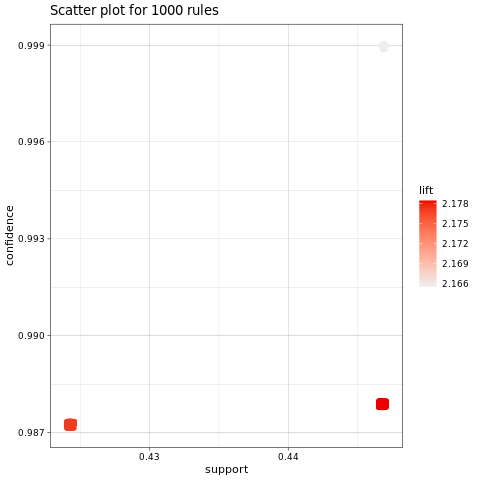

In [290]:
%%R
plot(topRules)

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



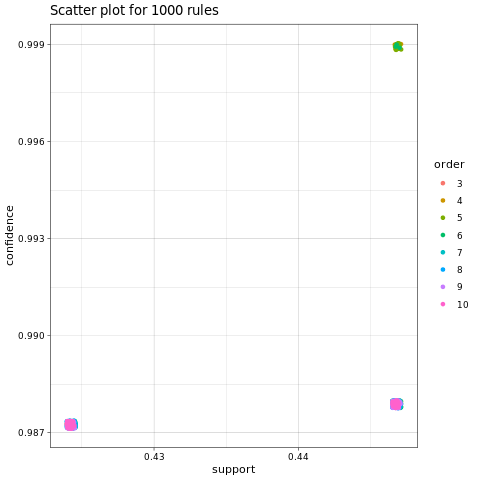

In [291]:
%%R

plot(topRules, method = "two-key plot")

    lhs                                      rhs                                   support confidence coverage     lift count
[1] {bandDistance_speed#6HR#30MIN#ASC=m,                                                                                     
     bandDistance_speed#6HR#30MIN#CID=m}  => {bandDistance_pace#6HR#30MIN#AVG=m} 0.4468985  0.9878809 0.452381 2.178457  2853
NULL


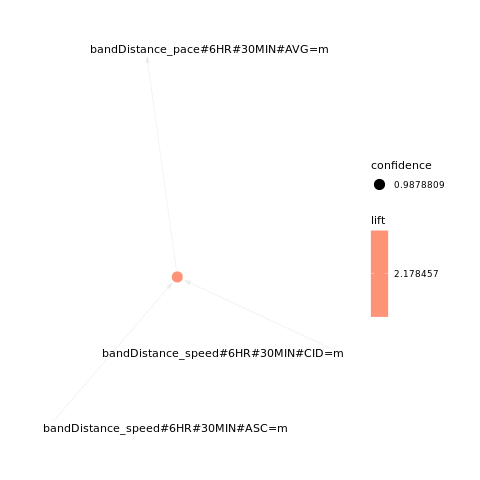

In [294]:
%%R
print(inspect(head(topRules,1)))
plot(head(topRules,1), method = "graph",     measure = "confidence", shading = "lift")



In [ ]:
%%R
saveAsGraph(head(topRules, n = 10, by = "lift"), file = "rules.graphml")

## MLTrainEvalSet

In [295]:
num_interventions= labels_ml.shape[0]
print('there are {:.0f} participants with {} interventions in total'.format( labels_ml.index.get_level_values('pid').nunique(),num_interventions))

there are 38 participants with 1746 interventions in total


In [504]:
test_size = .2
dev_interventions = (1-test_size)*num_interventions
print("Dev:Test = {:.0f}:{:.0f} ".format( dev_interventions, num_interventions-dev_interventions))


val_size = .2
print("Train:Val = {:.0f}:{:.0f} ".format( (1-val_size)*dev_interventions, test_size*dev_interventions))

Dev:Test = 1397:349 
Train:Val = 1117:279 


### Full features

In [326]:
ml_full_features_d={}
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        full_featurs_ml = dataset.parallellize_extract(
            labels=labels_ml, 
            w_name=window_name,
            w_size = window_size,
            use_ray=True            
        )

        
    

2022-01-06 13:08:15,220	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
100%|██████████| 38/38 [05:31<00:00,  8.72s/it]  


#### Select the features

In [334]:
selected_features_mapped_to_fullFeatures = list(map(lambda x: x.replace('30MIN#',''), selected_features_mapped))
full_features_ml = full_features_ml[selected_features_mapped_to_fullFeatures]

#### imputation

In [335]:
full_features_ml.isnull().sum()

activity_event#6HR#ETP                                  40
battery_temperature#6HR#VAR                             32
bandUV_indexLevel#6HR#ETP                               16
bandUV_exposure#6HR#MAX                                 17
data_RX2TX#6HR#ASC                                      32
battery_plugState#6HR#SUP:WIRELESS                    1577
appUsage_appCategory#6HR#SUP:Productivity/Business    1126
location_distance#6HR#CID                               34
data_RX#6HR#CID                                         32
battery_plugState#6HR#SUP:AC                           520
location_cluster#6HR#ETP                                33
bandDistance_speed#6HR#ASC                              16
bandUV_indexLevel#6HR#ASC                               16
battery_status#6HR#ETP                                  32
appUsage_appCategory#6HR#SUP:Social/Communication      110
bandDistance_speed#6HR#CID                              16
data_RX2TX#6HR#CID                                      

In [336]:

full_features_ml = impute_by_filling_support_features(full_features_ml)
full_features_ml.iloc[:,full_features_ml.columns.str.contains('SUP')].std().sum()

  0%|          | 0/38 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
100%|██████████| 38/38 [00:00<00:00, 199.48it/s]


0.7692335251374586

In [337]:
df_sub_ml = impute_with_mean_of_participant(df_sub_ml)
df_sub_ml.isnull().sum()

100%|██████████| 38/38 [00:00<00:00, 101.13it/s]


bandGSR_resistance#6HR#30MIN#MAXLAGVAL                      0
bandHeartRate_RRInterval#6HR#30MIN#MAXLAG                   0
bandUV_indexLevel#6HR#30MIN#ETP                             0
bandUV_indexLevel#6HR#30MIN#ASC                             0
bandUV_exposure#6HR#30MIN#MAX                               0
bandUV_exposure#6HR#30MIN#BEP                               0
bandDistance_pace#6HR#30MIN#AVG                             0
bandDistance_speed#6HR#30MIN#ASC                            0
bandDistance_speed#6HR#30MIN#CID                            0
appUsage_appCategory#6HR#30MIN#ETP                          0
battery_temperature#6HR#30MIN#MAX                           0
battery_temperature#6HR#30MIN#VAR                           0
battery_temperature#6HR#30MIN#ASC                           0
battery_temperature#6HR#30MIN#LTI                           0
battery_level#6HR#30MIN#MIN                                 0
battery_level#6HR#30MIN#VAR                                 0
battery_

#### Classification

In [338]:

data = pd.merge(labels_ml[['is_opportune_moment']], full_features_ml, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        939
non-receptive    807
Name: is_opportune_moment, dtype: int64


2022-01-06 13:18:20,074	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
38it [00:00, 202.23it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,53.393124,51.775355


- using reduced ML set

In [346]:


data = pd.merge(labels_ml[['is_opportune_moment']], full_features_ml, left_index=True, right_index=True )
data = pd.merge(data, featuresCFF[[]],left_index=True, right_index=True)# to reduce
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

is_opportune_moment  activity_event#6HR#ETP  \
pid  timestamp                                                         
1510 2019-05-16 11:17:00       non-receptive                     NaN   
     2019-05-16 12:56:00           receptive                     NaN   
     2019-05-16 19:40:00       non-receptive                0.839470   
     2019-05-17 10:43:00           receptive                0.000000   
     2019-05-17 11:28:00       non-receptive                0.000000   
...                                      ...                     ...   
707  2019-05-12 14:15:00           receptive                0.086907   
     2019-05-13 15:59:00       non-receptive                0.328124   
     2019-05-13 16:41:00       non-receptive                0.328124   
     2019-05-13 20:26:00       non-receptive                0.251117   
     2019-05-14 16:41:00           receptive                0.269629   

                          battery_temperature#6HR#VAR  \
pid  timestamp                                          
1510 2019-05-16 11:17:00                          NaN   
     2019-05-16 12:56:00                          NaN   
     2019-05-16 19:40:00                    10.333306   
     2019-05-17 10:43:00                     3.661834   
     2019-05-17 11:28:00                     3.304665   
...                                               ...   
707  2019-05-12 14:15:00                    15.049544   
     2019-05-13 15:59:00                     4.188944   
     2019-05-13 16:41:00                     3.912996   
     2019-05-13 20:26:00                     1.873101   
     2019-05-14 16:41:00                     7.841677   

                          bandUV_indexLevel#6HR#ETP  bandUV_exposure#6HR#MAX  \
pid  timestamp                                                                 
1510 2019-05-16 11:17:00                   0.074876                      0.0   
     2019-05-16 12:56:00                   0.171811                      0.0   
     2019-05-16 19:40:00                   0.000000                      0.0   
     2019-05-17 10:43:00                   0.000000                      0.0   
     2019-05-17 11:28:00                   0.000000                      0.0   
...                                             ...                      ...   
707  2019-05-12 14:15:00                   0.019124                      0.0   
     2019-05-13 15:59:00                   0.000000                      0.0   
     2019-05-13 16:41:00                   0.000000                      0.0   
     2019-05-13 20:26:00                   0.000000                      0.0   
     2019-05-14 16:41:00                   0.000000                      0.0   

                          data_RX2TX#6HR#ASC  \
pid  timestamp                                 
1510 2019-05-16 11:17:00                 NaN   
     2019-05-16 12:56:00                 NaN   
     2019-05-16 19:40:00        10983.043729   
     2019-05-17 10:43:00         8515.951718   
     2019-05-17 11:28:00        10760.760718   
...                                      ...   
707  2019-05-12 14:15:00         5563.476992   
     2019-05-13 15:59:00         1980.211800   
     2019-05-13 16:41:00         2136.159732   
     2019-05-13 20:26:00         1796.623266   
     2019-05-14 16:41:00         4585.495645   

                          battery_plugState#6HR#SUP:WIRELESS  \
pid  timestamp                                                 
1510 2019-05-16 11:17:00                            0.000000   
     2019-05-16 12:56:00                            0.000000   
     2019-05-16 19:40:00                            0.122308   
     2019-05-17 10:43:00                            0.000000   
     2019-05-17 11:28:00                            0.000000   
...                                                      ...   
707  2019-05-12 14:15:00                            0.000000   
     2019-05-13 15:59:00                            0.000000   
     2019-05-13 16:41:00                

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 13:37:44,036	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
30it [00:00, 185.56it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,47.56562,47.729201



### Agg 

#### extract sub features
- extract sub features only for selected 


In [297]:
selected_features_mapped[:3]

['activity_event#6HR#30MIN#ETP',
 'battery_temperature#6HR#30MIN#VAR',
 'bandUV_indexLevel#6HR#30MIN#ETP']

In [298]:
ml_sub_features_d={}
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        ml_sub_features_d[window_name] = dataset.parallellize_extract_sub(
            labels=labels_ml, 
            w_name=window_name,
            w_size = window_size,
            selected_features=selected_features_mapped,
            use_ray=True            
        )

        
    

2022-01-06 12:18:40,800	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
 16%|█▌        | 6/38 [03:40<12:26, 23.33s/it]   (pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
(pid=3431)   **kwargs)
(pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
(pid=3431)   ret = ret.dtype.type(ret / rcount)
(pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
(pid=3431)   slope = ssxym / ssxm
(pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
(pid=3431)   t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
(pid=3431) /data/juma/anacon

In [318]:
df_sub_ml = ml_sub_features_d['6HR']
df_sub_ml.to_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv')
df_sub_ml = pd.read_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv', dtype={'pid':'str'},
                     parse_dates=['timestamp'])
df_sub_ml.set_index(['pid','timestamp','sub_timestamp'], inplace=True)

df_sub_ml

bandGSR_resistance#6HR#30MIN#MAXLAGVAL  \
pid  timestamp           sub_timestamp                                                 
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                                     NaN   
                         2019-05-16 04:39:00                                     NaN   
                         2019-05-16 05:09:00                                     NaN   
                         2019-05-16 05:39:00                                     NaN   
                         2019-05-16 06:09:00                                     NaN   
...                                                                              ...   
707  2019-05-14 16:41:00 2019-05-14 14:11:00                                0.998889   
                         2019-05-14 14:41:00                                0.998889   
                         2019-05-14 15:11:00                                0.998889   
                         2019-05-14 15:41:00                                0.998889   
                         2019-05-14 16:11:00                                0.998889   

                                              bandHeartRate_RRInterval#6HR#30MIN#MAXLAG  \
pid  timestamp           sub_timestamp                                                    
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                                        NaN   
                         2019-05-16 04:39:00                                        NaN   
                         2019-05-16 05:09:00                                        NaN   
                         2019-05-16 05:39:00                                        NaN   
                         2019-05-16 06:09:00                                        NaN   
...                                                                                 ...   
707  2019-05-14 16:41:00 2019-05-14 14:11:00                                        0.0   
                         2019-05-14 14:41:00                                        0.0   
                         2019-05-14 15:11:00                                        0.0   
                         2019-05-14 15:41:00                                        0.0   
                         2019-05-14 16:11:00                                        0.0   

                                              bandUV_indexLevel#6HR#30MIN#ETP  \
pid  timestamp           sub_timestamp                                          
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                              NaN   
                         2019-05-16 04:39:00                              NaN   
                         2019-05-16 05:09:00                              NaN   
                         2019-05-16 05:39:00                              NaN   
                         2019-05-16 06:09:00                              NaN   
...                                                                       ...   
707  2019-05-14 16:41:00 2019-05-14 14:11:00                              0.0   
                         2019-05-14 14:41:00                              0.0   
                         2019-05-14 15:11:00                              0.0   
                         2019-05-14 15:41:00                              0.0   
                         2019-05-14 16:11:00                              0.0   

                                              bandUV_indexLevel#6HR#30MIN#ASC  \
pid  timestamp           sub_timestamp                                          
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                              NaN   
                         2019-05-16 04:39:00                              NaN   
                         2019-05-16 05:09:00                              NaN   
                         2019-05-16 05:39:00                              NaN   
                         2019-05-16 06:09:00                              NaN   
...                                                                       ...   
707  2019-05-14

#### impute

In [319]:

df_sub_ml = impute_by_filling_support_features(df_sub_ml)
df_sub_ml.iloc[:,df_sub_ml.columns.str.contains('SUP')].std().sum()

  0%|          | 0/38 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 38/38 [00:00<00:00, 152.69it/s]


1.1764081952945167

In [320]:
df_sub_ml = impute_with_mean_of_participant(df_sub_ml)
df_sub_ml.shape

100%|██████████| 38/38 [00:00<00:00, 85.03it/s]


(20952, 30)

In [321]:
agg_feature_ml = df_sub_ml.groupby(['pid','timestamp']).agg(['mean','std'])
agg_feature_ml.columns = agg_feature_ml.columns.map('|'.join).str.strip('|')
agg_feature_ml = drop_zero_varience_features(agg_feature_ml)

0 from total of 60 is dropped


In [324]:
agg_feature_ml

bandGSR_resistance#6HR#30MIN#MAXLAGVAL|mean  \
pid  timestamp                                                          
1510 2019-05-16 10:09:00                                     0.880691   
     2019-05-16 11:17:00                                     0.871573   
     2019-05-16 12:56:00                                     0.916066   
     2019-05-16 19:40:00                                     0.998884   
     2019-05-17 10:43:00                                     0.998561   
...                                                               ...   
729  2019-05-14 18:10:00                                     0.991243   
     2019-05-14 18:53:00                                     0.982673   
     2019-05-14 19:33:00                                     0.985188   
     2019-05-14 20:16:00                                     0.994979   
     2019-05-14 21:02:00                                     0.937456   

                          bandGSR_resistance#6HR#30MIN#MAXLAGVAL|std  \
pid  timestamp                                                         
1510 2019-05-16 10:09:00                                    0.000000   
     2019-05-16 11:17:00                                    0.036182   
     2019-05-16 12:56:00                                    0.055526   
     2019-05-16 19:40:00                                    0.000019   
     2019-05-17 10:43:00                                    0.001137   
...                                                              ...   
729  2019-05-14 18:10:00                                    0.011736   
     2019-05-14 18:53:00                                    0.020581   
     2019-05-14 19:33:00                                    0.018608   
     2019-05-14 20:16:00                                    0.003739   
     2019-05-14 21:02:00                                    0.189518   

                          bandHeartRate_RRInterval#6HR#30MIN#MAXLAG|mean  \
pid  timestamp                                                             
1510 2019-05-16 10:09:00                                        0.000000   
     2019-05-16 11:17:00                                        0.000000   
     2019-05-16 12:56:00                                        0.000000   
     2019-05-16 19:40:00                                        0.000000   
     2019-05-17 10:43:00                                        0.000000   
...                                                                  ...   
729  2019-05-14 18:10:00                                        0.000000   
     2019-05-14 18:53:00                                        0.000000   
     2019-05-14 19:33:00                                        0.083333   
     2019-05-14 20:16:00                                        0.000000   
     2019-05-14 21:02:00                                        0.000000   

                          bandHeartRate_RRInterval#6HR#30MIN#MAXLAG|std  \
pid  timestamp                                                            
1510 2019-05-16 10:09:00                                       0.000000   
     2019-05-16 11:17:00                                       0.000000   
     2019-05-16 12:56:00                                       0.000000   
     2019-05-16 19:40:00                                       0.000000   
     2019-05-17 10:43:00                                       0.000000   
...                                                                 ...   
729  2019-05-14 18:10:00                                       0.000000   
     2019-05-14 18:53:00                                       0.000000   
     2019-05-14 19:33:00                                       0.288675   
     2019-05-14 20:16:00                                       0.000000   
     2019-05-14 21:02:00                                       0.000000   

                          bandUV_indexLevel#6HR#30MIN#ETP|mean  \
pid  timestamp                                                   
1510 2019-05-16 10:09:00                  

#### Classification performance

In [323]:

data = pd.merge(labels_ml[['is_opportune_moment']], agg_feature_ml, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        939
non-receptive    807
Name: is_opportune_moment, dtype: int64


2022-01-06 13:05:25,692	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
38it [00:00, 195.47it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,45.500195,50.665359


- reduced set

In [348]:
data = pd.merge(labels_ml[['is_opportune_moment']], agg_feature_ml, left_index=True, right_index=True )
data = pd.merge(data, featuresCFF[[]],left_index=True, right_index=True)# to reduce
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 13:39:13,377	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
30it [00:00, 172.05it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,42.112005,46.985952


(20952, 30)

### CFF
- impute
- recode

In [ ]:
df_sub_ml = pd.read_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv', dtype={'pid':'str'},
                     parse_dates=['timestamp'])
df_sub_ml.set_index(['pid','timestamp','sub_timestamp'], inplace=True)


df_sub_ml = impute_by_filling_support_features(df_sub_ml)

df_sub_ml.isnull().sum(axis=0).sort_values(ascending=False)

#### recode

In [302]:
df_sub_ml_recoded = [] 
for pid in tqdm(df_sub_ml.index.get_level_values('pid').unique()):    
    res = discretize_df(df_sub_ml.loc[pid],df_sub_ml.columns.tolist(), pid)
    
    df_sub_ml_recoded.append(res)
    
df_sub_ml_recoded = pd.concat(df_sub_ml_recoded)
df_sub_ml_recoded = df_sub_ml_recoded.reset_index().set_index(['pid', 'timestamp','sub_timestamp'])
df_sub_ml_recoded = df_sub_ml_recoded.astype('object').fillna('missing').astype('category')

  8%|▊         | 3/38 [00:00<00:03,  8.94it/s]

The numbers of 1-3 labels of PID1510 are: 17, 1, 12
The numbers of 1-3 labels of PID3023 are: 12, 4, 14
The numbers of 1-3 labels of PID3013 are: 16, 0, 14


 13%|█▎        | 5/38 [00:00<00:03,  9.84it/s]

The numbers of 1-3 labels of PID727 are: 14, 3, 13
The numbers of 1-3 labels of PID710 are: 15, 2, 13
The numbers of 1-3 labels of PID3025 are: 11, 5, 14


 24%|██▎       | 9/38 [00:00<00:02, 10.71it/s]

The numbers of 1-3 labels of PID714 are: 16, 1, 13
The numbers of 1-3 labels of PID702 are: 14, 3, 13
The numbers of 1-3 labels of PID729 are: 15, 1, 14


 29%|██▉       | 11/38 [00:01<00:02, 11.73it/s]

The numbers of 1-3 labels of PID1527 are: 15, 2, 13
The numbers of 1-3 labels of PID1541 are: 15, 5, 10
The numbers of 1-3 labels of PID3029 are: 14, 4, 12


 39%|███▉      | 15/38 [00:01<00:01, 13.33it/s]

The numbers of 1-3 labels of PID716 are: 16, 1, 13
The numbers of 1-3 labels of PID708 are: 15, 2, 13
The numbers of 1-3 labels of PID3041 are: 16, 0, 14
The numbers of 1-3 labels of PID3024 are: 18, 0, 12


 50%|█████     | 19/38 [00:01<00:01, 14.17it/s]

The numbers of 1-3 labels of PID3027 are: 17, 7, 6
The numbers of 1-3 labels of PID709 are: 16, 1, 13
The numbers of 1-3 labels of PID723 are: 11, 5, 14
The numbers of 1-3 labels of PID704 are: 13, 2, 15


 61%|██████    | 23/38 [00:01<00:01, 14.38it/s]

The numbers of 1-3 labels of PID703 are: 11, 6, 13
The numbers of 1-3 labels of PID706 are: 18, 0, 12
The numbers of 1-3 labels of PID722 are: 16, 1, 13


 66%|██████▌   | 25/38 [00:01<00:00, 14.39it/s]

The numbers of 1-3 labels of PID1525 are: 16, 0, 14
The numbers of 1-3 labels of PID1517 are: 16, 2, 12
The numbers of 1-3 labels of PID3030 are: 10, 3, 17
The numbers of 1-3 labels of PID717 are: 15, 1, 14


 76%|███████▋  | 29/38 [00:02<00:00, 14.58it/s]

The numbers of 1-3 labels of PID711 are: 16, 1, 13
The numbers of 1-3 labels of PID3005 are: 16, 1, 13
The numbers of 1-3 labels of PID1522 are: 10, 6, 14


 87%|████████▋ | 33/38 [00:02<00:00, 14.57it/s]

The numbers of 1-3 labels of PID3010 are: 24, 3, 3
The numbers of 1-3 labels of PID3019 are: 14, 3, 13
The numbers of 1-3 labels of PID1516 are: 14, 3, 13
The numbers of 1-3 labels of PID3001 are: 15, 2, 13


 97%|█████████▋| 37/38 [00:02<00:00, 14.85it/s]

The numbers of 1-3 labels of PID1523 are: 14, 5, 11
The numbers of 1-3 labels of PID705 are: 16, 1, 13
The numbers of 1-3 labels of PID713 are: 11, 5, 14
The numbers of 1-3 labels of PID707 are: 16, 1, 13


100%|██████████| 38/38 [00:02<00:00, 13.29it/s]


In [509]:
df_sub_ml_recoded.shape

(20952, 38)

#### extract 

- for each rule
  - select the df that satisfy the context
     - extract Y from contextually filtered subfeatures and add to features


In [339]:
TOPK_RULES = 40
rules_df = pd.read_csv('rules/rules1000-mlen_10.csv', usecols=['rules','lift'], dtype={'lift':float})
rules_df = rules_df.iloc[:TOPK_RULES]
rules_df = rules_df[rules_df.lift>1.05]

#rules_df.rules = rules_df.rules.str.replace('.SUP.','.SUP:').str.replace('.','#')
featuresCFF = pd.DataFrame()# we store CFF here


for i,rule in (rules_df.iterrows()):
    context, y = rule['rules'].split(' => ')
    
    #clean `{`
    context = context[1:-1]    
    y = y[1:-1]
    
    #'BND_DST_PAC#3HR#30MIN#VAR=m' =>'BND_DST_PAC#3HR#30MIN#VAR'
    y=y.split('=')[0]    
    
    # flag the indices that satisfy our context
    index_flag = True
    for c in context.split(','): #'BND_DST_PAC#3HR#30MIN#VAR=m', 'BND_DST_SPD#3HR#30MIN#BEP=m'
        name, val = c.split('=')
        index_flag = index_flag & (df_sub_ml_recoded[name]==val)        
    featuresCFF[f'mean-{y}-context_{context}'] = df_sub_ml[index_flag][y].groupby(['pid','timestamp']).mean()
    featuresCFF[f'std-{y}-context_{context}'] = df_sub_ml[index_flag][y].groupby(['pid','timestamp']).std()
    

In [340]:
featuresCFF.shape # topK =400 rules

(1306, 80)

In [304]:
features.head()

mean-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                 
1510 2019-05-16 11:17:00                                         250.048078                                                                    
     2019-05-16 12:56:00                                         129.206926                                                                    
     2019-05-16 19:40:00                                           0.000000                                                                    
     2019-05-17 10:43:00                                           0.000000                                                                    
     2019-05-17 11:28:00                                           0.000000                                                                    

                          std-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                
1510 2019-05-16 11:17:00                                          69.809687                                                                   
     2019-05-16 12:56:00                                          75.606613                                                                   
     2019-05-16 19:40:00                                           0.000000                                                                   
     2019-05-17 10:43:00                                           0.000000                                                                   
     2019-05-17 11:28:00                                           0.000000                                                                   

                          mean-bandDistance_pace#6HR#30MIN#AVG-context_bandUV_indexLevel#6HR#30MIN#ETP=m,bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                                                   
1510 2019-05-16 11:17:00                                         250.048078                                                                                                      
     2019-05-16 12:56:00                                         129.206926                                                                                                      
     2019-05-16 19:40:00                                           0.000000                                                                                                      
     2019-05-17 10:43:00                                           0.000000                                                                                                      
     2019-05-17 11:28:00                                           0.000000                                                                                                      

                          std-bandDistance_pace#6HR#30MIN#AVG-context_bandUV_indexLevel#6HR#30MIN#ETP=m,bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                                                  
1510 2019-05-16 11:17:00                                          69.809687                                                                                                     
     2019-05-16 12:56:00                                          75.606613                                                                                                     
     2019-05-16 19:40:00                                    

In [341]:
featuresCFF = impute_with_mean_of_participant(featuresCFF)


100%|██████████| 30/30 [00:00<00:00, 46.54it/s]


Empty DataFrame
Columns: []
Index: [(1510, 2019-05-16 11:17:00), (1510, 2019-05-16 12:56:00), (1510, 2019-05-16 19:40:00), (1510, 2019-05-17 10:43:00), (1510, 2019-05-17 11:28:00), (1510, 2019-05-17 12:09:00), (1510, 2019-05-17 12:57:00), (1510, 2019-05-17 14:27:00), (1510, 2019-05-17 15:14:00), (1510, 2019-05-17 16:44:00), (1510, 2019-05-17 19:33:00), (1510, 2019-05-18 11:15:00), (1510, 2019-05-18 11:55:00), (1510, 2019-05-18 13:29:00), (1510, 2019-05-18 15:52:00), (1510, 2019-05-18 21:07:00), (1510, 2019-05-19 10:53:00), (1510, 2019-05-19 11:36:00), (1510, 2019-05-19 13:36:00), (1510, 2019-05-19 16:27:00), (1510, 2019-05-19 18:03:00), (1510, 2019-05-19 21:53:00), (1510, 2019-05-20 12:04:00), (1510, 2019-05-20 15:10:00), (1510, 2019-05-20 16:39:00), (1510, 2019-05-20 17:28:00), (1510, 2019-05-21 10:15:00), (1510, 2019-05-21 13:37:00), (1510, 2019-05-21 16:43:00), (1510, 2019-05-22 10:11:00), (1510, 2019-05-22 11:08:00), (1510, 2019-05-22 13:29:00), (1516, 2019-05-16 14:29:00), (1516, 2019-05-16 15:09:00), (1516, 2019-05-16 15:57:00), (1516, 2019-05-16 16:37:00), (1516, 2019-05-16 18:14:00), (1516, 2019-05-16 18:54:00), (1516, 2019-05-16 19:41:00), (1516, 2019-05-16 20:25:00), (1516, 2019-05-16 21:13:00), (1516, 2019-05-16 21:55:00), (1516, 2019-05-17 12:14:00), (1516, 2019-05-17 12:55:00), (1516, 2019-05-17 13:43:00), (1516, 2019-05-17 14:24:00), (1516, 2019-05-17 15:10:00), (1516, 2019-05-17 17:27:00), (1516, 2019-05-17 18:49:00), (1516, 2019-05-17 20:29:00), (1516, 2019-05-17 21:14:00), (1516, 2019-05-18 10:42:00), (1516, 2019-05-18 11:29:00), (1516, 2019-05-18 12:11:00), (1516, 2019-05-18 12:57:00), (1516, 2019-05-18 13:38:00), (1516, 2019-05-18 16:37:00), (1516, 2019-05-18 18:11:00), (1516, 2019-05-18 18:57:00), (1516, 2019-05-18 19:44:00), (1516, 2019-05-18 20:25:00), (1516, 2019-05-18 21:11:00), (1516, 2019-05-19 12:07:00), (1516, 2019-05-19 14:26:00), (1516, 2019-05-19 15:09:00), (1516, 2019-05-19 16:33:00), (1516, 2019-05-19 18:11:00), (1516, 2019-05-19 19:41:00), (1516, 2019-05-19 20:29:00), (1516, 2019-05-19 21:59:00), (1516, 2019-05-20 10:32:00), (1516, 2019-05-20 12:11:00), (1516, 2019-05-20 13:43:00), (1516, 2019-05-20 14:26:00), (1516, 2019-05-20 15:59:00), (1516, 2019-05-20 17:28:00), (1516, 2019-05-20 18:14:00), (1516, 2019-05-20 18:56:00), (1516, 2019-05-20 19:42:00), (1516, 2019-05-20 20:22:00), (1516, 2019-05-20 21:02:00), (1516, 2019-05-20 21:49:00), (1516, 2019-05-21 10:14:00), (1516, 2019-05-21 12:55:00), (1516, 2019-05-21 13:41:00), (1516, 2019-05-21 15:56:00), (1516, 2019-05-21 17:27:00), (1516, 2019-05-21 18:12:00), (1516, 2019-05-21 18:59:00), (1516, 2019-05-21 19:44:00), (1516, 2019-05-21 21:09:00), (1516, 2019-05-22 10:37:00), (1516, 2019-05-22 11:17:00), (1516, 2019-05-22 12:08:00), (1516, 2019-05-22 15:55:00), (1516, 2019-05-22 18:10:00), (1516, 2019-05-22 18:56:00), (1516, 2019-05-22 19:43:00), (1516, 2019-05-22 20:26:00), (1516, 2019-05-22 21:58:00), ...]

[1306 rows x 0 columns]

#### Classifier Performance

In [344]:
data = pd.merge(labels_ml[['is_opportune_moment']], featuresCFF, left_index=True, right_index=True )
data

is_opportune_moment  \
pid  timestamp                                 
1510 2019-05-16 11:17:00       non-receptive   
     2019-05-16 12:56:00           receptive   
     2019-05-16 19:40:00       non-receptive   
     2019-05-17 10:43:00           receptive   
     2019-05-17 11:28:00       non-receptive   
...                                      ...   
707  2019-05-12 14:15:00           receptive   
     2019-05-13 15:59:00       non-receptive   
     2019-05-13 16:41:00       non-receptive   
     2019-05-13 20:26:00       non-receptive   
     2019-05-14 16:41:00           receptive   

                          mean-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                 
1510 2019-05-16 11:17:00                                         250.048078                                                                    
     2019-05-16 12:56:00                                         129.206926                                                                    
     2019-05-16 19:40:00                                           0.000000                                                                    
     2019-05-17 10:43:00                                           0.000000                                                                    
     2019-05-17 11:28:00                                           0.000000                                                                    
...                                                                     ...                                                                    
707  2019-05-12 14:15:00                                           8.992331                                                                    
     2019-05-13 15:59:00                                           0.000000                                                                    
     2019-05-13 16:41:00                                           0.000000                                                                    
     2019-05-13 20:26:00                                           0.000000                                                                    
     2019-05-14 16:41:00                                           0.000000                                                                    

                          std-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                
1510 2019-05-16 11:17:00                                          69.809687                                                                   
     2019-05-16 12:56:00                                          75.606613                                                                   
     2019-05-16 19:40:00                                           0.000000                                                                   
     2019-05-17 10:43:00                                           0.000000                                                                   
     2019-05-17 11:28:00                                           0.000000                                                                   
...                                                                     ...                                                                   
707  2019-05-12 14:15:00                                          25.179918                                                                   
     2019-05-13 15:59:00                                           0.000000                                                                   
     2019-05-13 16:41:00                                           0.000000                      

In [314]:

data = pd.merge(labels_ml[['is_opportune_moment']], features, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 12:47:47,002	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
30it [00:00, 222.27it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,50.631212,48.185141


,ACC,ACC_BAL
CV_TYPE,,
LOSO,50.631212,48.185141


### Combining

In [351]:
full_features_ml.shape

(1746, 30)

In [352]:
featuresCFF.shape

(1306, 80)

In [353]:
agg_feature_ml.shape

(1746, 60)

In [349]:
data = pd.merge(full_features_ml, featuresCFF, left_index=True, right_index=True )
data = pd.merge(data, agg_feature_ml, left_index=True, right_index=True )
data = pd.merge(labels_ml[['is_opportune_moment']], data, left_index=True, right_index=True )
data

is_opportune_moment  activity_event#6HR#ETP  \
pid  timestamp                                                         
1510 2019-05-16 11:17:00       non-receptive                     NaN   
     2019-05-16 12:56:00           receptive                     NaN   
     2019-05-16 19:40:00       non-receptive                0.839470   
     2019-05-17 10:43:00           receptive                0.000000   
     2019-05-17 11:28:00       non-receptive                0.000000   
...                                      ...                     ...   
707  2019-05-12 14:15:00           receptive                0.086907   
     2019-05-13 15:59:00       non-receptive                0.328124   
     2019-05-13 16:41:00       non-receptive                0.328124   
     2019-05-13 20:26:00       non-receptive                0.251117   
     2019-05-14 16:41:00           receptive                0.269629   

                          battery_temperature#6HR#VAR  \
pid  timestamp                                          
1510 2019-05-16 11:17:00                          NaN   
     2019-05-16 12:56:00                          NaN   
     2019-05-16 19:40:00                    10.333306   
     2019-05-17 10:43:00                     3.661834   
     2019-05-17 11:28:00                     3.304665   
...                                               ...   
707  2019-05-12 14:15:00                    15.049544   
     2019-05-13 15:59:00                     4.188944   
     2019-05-13 16:41:00                     3.912996   
     2019-05-13 20:26:00                     1.873101   
     2019-05-14 16:41:00                     7.841677   

                          bandUV_indexLevel#6HR#ETP  bandUV_exposure#6HR#MAX  \
pid  timestamp                                                                 
1510 2019-05-16 11:17:00                   0.074876                      0.0   
     2019-05-16 12:56:00                   0.171811                      0.0   
     2019-05-16 19:40:00                   0.000000                      0.0   
     2019-05-17 10:43:00                   0.000000                      0.0   
     2019-05-17 11:28:00                   0.000000                      0.0   
...                                             ...                      ...   
707  2019-05-12 14:15:00                   0.019124                      0.0   
     2019-05-13 15:59:00                   0.000000                      0.0   
     2019-05-13 16:41:00                   0.000000                      0.0   
     2019-05-13 20:26:00                   0.000000                      0.0   
     2019-05-14 16:41:00                   0.000000                      0.0   

                          data_RX2TX#6HR#ASC  \
pid  timestamp                                 
1510 2019-05-16 11:17:00                 NaN   
     2019-05-16 12:56:00                 NaN   
     2019-05-16 19:40:00        10983.043729   
     2019-05-17 10:43:00         8515.951718   
     2019-05-17 11:28:00        10760.760718   
...                                      ...   
707  2019-05-12 14:15:00         5563.476992   
     2019-05-13 15:59:00         1980.211800   
     2019-05-13 16:41:00         2136.159732   
     2019-05-13 20:26:00         1796.623266   
     2019-05-14 16:41:00         4585.495645   

                          battery_plugState#6HR#SUP:WIRELESS  \
pid  timestamp                                                 
1510 2019-05-16 11:17:00                            0.000000   
     2019-05-16 12:56:00                            0.000000   
     2019-05-16 19:40:00                            0.122308   
     2019-05-17 10:43:00                            0.000000   
     2019-05-17 11:28:00                            0.000000   
...                                                      ...   
707  2019-05-12 14:15:00                            0.000000   
     2019-05-13 15:59:00                            0.000000   
     2019-05-13 16:41:00                

In [350]:
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 13:43:45,833	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
13it [00:00, 125.25it/s]

start conducting LOSO trials


30it [00:00, 138.46it/s]


,ACC,ACC_BAL
CV_TYPE,,
LOSO,48.607912,47.705575
